## Nota sobre los cambios respecto al notebook original

En esta versi√≥n del proyecto, he realizado varios cambios respecto al c√≥digo base proporcionado:

- **Uso de Polars en vez de pandas:**  
  He optado por seguir utilizando Polars para la manipulaci√≥n de datos en Python, ya que es una librer√≠a m√°s eficiente y r√°pida para grandes vol√∫menes de datos, adem√°s de ofrecer una sintaxis moderna y muy potente para an√°lisis y transformaciones.

- **Conexi√≥n a la base de datos con SQLAlchemy:**  
  En lugar de conectores m√°s simples como `mysql-connector` o `pymysql`, sigo utilizando SQLAlchemy, que es m√°s flexible y profesional, y permite una mejor gesti√≥n de conexiones, transacciones y portabilidad del c√≥digo.

- **Gesti√≥n de credenciales con dotenv:**  
  Para evitar exponer contrase√±as y par√°metros sensibles en el c√≥digo, he usado la librer√≠a `python-dotenv` y guardo los datos de conexi√≥n en un archivo `.env`, que est√° excluido del repositorio con `.gitignore` para mayor seguridad.

- **Manejo de errores y c√≥digo m√°s robusto:**  
  Se ha a√±adido control de errores y mensajes informativos en las funciones de consulta para asegurar que cualquier fallo en la conexi√≥n o en las queries sea f√°cil de identificar y depurar, acci√≥n que ayuda mucho para identificar errores de todo tipo.

En definitiva, estos cambios son para seguir un poco la l√≥gica del primer notebook, y seguir usando las mismas librer√≠as y dependencias.


In [1]:
# Importamos todas las dependencias necesarias (a priori)

import pandas as pd
import numpy as np
import polars as pl

from dotenv import load_dotenv
import os

import datetime

from meteostat import Point, Daily
import sqlalchemy as sa
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno

## 1. Consulta a la base de datos

In [2]:
# Paso hecho anteriormente en el notebook 02, he visto que aqu√≠ tambi√©n est√° as√≠ que vuelvo a hacer este paso
class DatabaseConnection:

    # Informaci√≥n necesaria para establecer la conexi√≥n a la BBDD
    def __init__(self):
        load_dotenv()  # Variables de entorno
        port = 3306  # Puerto por defecto de MySQL
        user = os.getenv("DB_USER")
        password = os.getenv("DB_PASSWORD")
        host = os.getenv("DB_HOST")
        nombre_base_datos = os.getenv("DB_NAME") 
        self.engine = create_engine(
            f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{nombre_base_datos}"
        )

    # Funci√≥n cuyo cometido es consultar una query a la BBDD y devolverla como un dataframe de Polars
    def query_to_polars(self, sql_query):
        try:
            with self.engine.connect() as conn:
                result = conn.execute(text(sql_query))
                columns = result.keys()
                rows = result.fetchall()
                if not rows:
                    print("Consulta ejecutada correctamente pero no hay resultados.")
                    return pl.DataFrame(schema=columns)
                print("Consulta ejecutada correctamente.")
                return pl.DataFrame(rows, schema=columns)
        except SQLAlchemyError as e:
            print(f"Error de SQLAlchemy al ejecutar la consulta:\{e}")
            return None
        except Exception as e:
            print(f"Error inesperado:\{e}")
            return None

# Usamos y probamos la clase
db = DatabaseConnection()

query = """
SELECT *
FROM ventas_diarias_estudio
WHERE ARTICULO = '3960'
"""

ventas_prueba = db.query_to_polars(query)
ventas_prueba




Consulta ejecutada correctamente.


shape: (730, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia  ‚îÜ tipo  ‚îÜ fechaVenta ‚îÜ festivo    ‚îÜ ‚Ä¶ ‚îÜ orden_arti ‚îÜ in_fecha_e ‚îÜ cantidad ‚îÜ importe    ‚îÇ
‚îÇ ---      ‚îÜ ---   ‚îÜ ---        ‚îÜ ---        ‚îÜ   ‚îÜ culo_famil ‚îÜ studio     ‚îÜ ---      ‚îÜ ---        ‚îÇ
‚îÇ str      ‚îÜ str   ‚îÜ date       ‚îÜ str        ‚îÜ   ‚îÜ ia         ‚îÜ ---        ‚îÜ f64      ‚îÜ f64        ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ ---        ‚îÜ str        ‚îÜ          ‚îÜ            ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ i64        ‚îÜ            ‚îÜ          ‚îÜ            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2021-05-01 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 4422.0   ‚îÜ 10250.1959 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 42         ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2021-05-02 ‚îÜ D√≠a de la  ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 4059.0   ‚îÜ 9408.76195 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ Madre      ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 8          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2021-05-03 ‚îÜ D√≠a de la  ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 2508.0   ‚îÜ 5813.54393 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ Cruz       ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 9          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2021-05-04 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 2607.0   ‚îÜ 6043.02598 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 6          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2021-05-05 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 3168.0   ‚îÜ 7343.42400 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 1          ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶     ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2023-04-26 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 1782.0   ‚îÜ 5832.48614 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 5          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2023-04-27 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 2376.0   ‚îÜ 7776.64819 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 3          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2023-04-28 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 2013.0   ‚îÜ 6588.54916 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 4          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2023-04-29 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 2739.0   ‚îÜ 8964.74722 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 3          ‚îÇ
‚îÇ BOLLERIA ‚îÜ VENTA ‚îÜ 2023-04-30 ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 1          ‚îÜ S          ‚îÜ 3630.0   ‚îÜ 11880.9902 ‚îÇ
‚îÇ          ‚îÜ       ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ          ‚îÜ 95         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚

In [3]:
# La Query est√° adaptada, usa mi base y mi tabla correcta (nombre)
# IMP: se omiten las columnas irrelevantes -> 'in_fecha_estudio' y 'tipo'
query_daily_and_top = """
SELECT  familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

FROM ventas_diarias_estudio_completo
"""
# !!ESCRIBIR EL "COMPLETO"!! tenia errores en la carga de datos por no a√±adir el "completo" en la consulta SQL

# Instanciar la clase con la contrase√±a de la BBDD (mejor ocultar la contrase√±a)
db = DatabaseConnection()

# Consultar la query anterior y devolverla como un dataframe de Polars
ventas = db.query_to_polars(query_daily_and_top)

# Convertir 'articulo' a entero en Polars, ya cambi√© el formato a "Date" al insertar las tablas en el primer notebook
ventas = ventas.with_columns([
    pl.col("articulo").cast(pl.Int64)
])

Consulta ejecutada correctamente.


In [4]:
ventas

shape: (10_574, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia    ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo ‚îÜ precio    ‚îÜ cantidad   ‚îÜ importe    ‚îÜ orden_arti ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---         ‚îÜ ---     ‚îÜ ---       ‚îÜ ---        ‚îÜ ---        ‚îÜ culo_famil ‚îÇ
‚îÇ str        ‚îÜ i64      ‚îÜ date        ‚îÜ str     ‚îÜ f64       ‚îÜ f64        ‚îÜ f64        ‚îÜ ia         ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ            ‚îÜ ---        ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ            ‚îÜ i64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ BOLLERIA   ‚îÜ 3880     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.591     ‚îÜ 3135.0     ‚îÜ 8122.78497 ‚îÜ 3          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 3          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 3960     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.318     ‚îÜ 4422.0     ‚îÜ 10250.1959 ‚îÜ 1          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 42         ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 5803     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.727     ‚îÜ 2607.0     ‚îÜ 7109.28878 ‚îÜ 5          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 8          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 6286     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 3.136     ‚îÜ 1815.0     ‚îÜ 5691.84006 ‚îÜ 4          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 9          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 6425     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 31.364    ‚îÜ 348.974995 ‚îÜ 10945.2429 ‚îÜ 2          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 16         ‚îÜ            ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6523     ‚îÜ 2023-05-17  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 132.0      ‚îÜ 5382.03601 ‚îÜ 3          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 1          ‚îÜ            ‚îÇ
‚îÇ PASTELERIA ‚îÜ 5403     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 85.800002  ‚îÜ 3498.31907 ‚îÜ 2          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 7          ‚îÜ            ‚îÇ
‚îÇ PASTELERIA ‚îÜ 5404     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 43.5      ‚îÜ 198.0      ‚îÜ 8613.0     ‚îÜ 1          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6451     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 43.5      ‚îÜ 33.0       ‚îÜ 1435.5     ‚îÜ 4          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6523     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 33.0       ‚îÜ 1345.50900 ‚îÜ 3          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 3          ‚îÜ            ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [5]:
# Voy a realizar una comprobaci√≥n de los tipos de las columnas (experimentaci√≥n con Polars)

for col, dtype in zip(ventas.columns, ventas.dtypes):
    print(f"{col}: {dtype}")

familia: String
articulo: Int64
fecha_venta: Date
festivo: String
precio: Float64
cantidad: Float64
importe: Float64
orden_articulo_familia: Int64


In [6]:
# Compruebo la columna festivo, no recordaba el formato y ahora veo el porqu√© del "String"
print(ventas["festivo"].head(10))

shape: (10,)
Series: 'festivo' [str]
[
	null
	null
	null
	null
	null
	"D√≠a de la Madre"
	"D√≠a de la Madre"
	"D√≠a de la Madre"
	"D√≠a de la Madre"
	"D√≠a de la Madre"
]


In [7]:
# El m√©todo ".select" ser√≠a lo correcto con Polars
print(ventas.select("festivo").unique())

shape: (27, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ festivo                         ‚îÇ
‚îÇ ---                             ‚îÇ
‚îÇ str                             ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ D√≠a de la Hispanidad (Fiesta N‚Ä¶ ‚îÇ
‚îÇ D√≠a de la Virgen del Carmen     ‚îÇ
‚îÇ D√≠a de la Cruz                  ‚îÇ
‚îÇ Domingo de Ramos                ‚îÇ
‚îÇ D√≠a del Padre                   ‚îÇ
‚îÇ ‚Ä¶                               ‚îÇ
‚îÇ A√±o Nuevo                       ‚îÇ
‚îÇ D√≠a de la Victoria              ‚îÇ
‚îÇ D√≠a de Todos los Santos         ‚îÇ
‚îÇ Nochevieja                      ‚îÇ
‚îÇ Fiesta de la Virgen de la Vict‚Ä¶ ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


## 2. Consulta a [meteostat API](https://dev.meteostat.net/python/daily.html)

Variables que se obtienen:

- **tavg** -> The average air temperature in ¬∞C
- **tmin** -> The minimum air temperature in ¬∞C
- **tmax** -> The maximum air temperature in ¬∞C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (¬∞)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [8]:
class DailyWeatherData:

    # Localizaci√≥n de la tienda de la Panader√≠a Salvador Echeverr√≠a
    ECHEVERRIA_SHOP = Point(36.721477644071705, -4.363132134392174)

    # Columnas identificadas como importantes
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Definici√≥n del horizonte temporal de la consulta a la API
    def __init__(self, start, end=None):
        self.start = DailyWeatherData._to_datetime(start)
        if end is not None:
            self.end = DailyWeatherData._to_datetime(end)
        else:
            self.end = datetime.datetime.now()

    # He tenido errores de formato datetime.datetime y datetime.date (end y start), con la siguiente funci√≥n soluciono el problema (creo que es tema de usar Polars)
    @staticmethod  # Uso un @staticmethod para llamar la clase directamente sin necesidad de crear un objeto antes
    def _to_datetime(dt):
        if isinstance(dt, datetime.datetime):
            return dt
        if isinstance(dt, datetime.date):  # Si es datetime.date, convierto SIEMPRE a datetime.datetime
            return datetime.datetime(dt.year, dt.month, dt.day)
        if hasattr(dt, "to_pydatetime"):  # Por si es Polars
            res = dt.to_pydatetime()
            # Por si meteostat devuelve date igualmente
            if isinstance(res, datetime.date) and not isinstance(res, datetime.datetime):
                return datetime.datetime(res.year, res.month, res.day)
            return res
        raise TypeError(f"No puedo convertir {dt} a datetime.datetime")

    # Se establece que la consulta ser√° diaria, se seleccionan todas las columnas imps y se a√±ade un suff.
    def get_weather_data(self, as_polars=True):   # A√±ado un argumento extra, recibir√© un df de Pandas y tengo que convertirlo a Polars
        start_dt = self._to_datetime(self.start)
        end_dt = self._to_datetime(self.end)
        print("start_dt:", start_dt, type(start_dt))
        print("end_dt:", end_dt, type(end_dt))
        daily_data = Daily(self.ECHEVERRIA_SHOP, start_dt, end_dt)
        data = daily_data.fetch()  # Aqu√≠ devuelve un df de Pandas
        df = data[self.IMP_COLUMNS]
        df.columns = [f"{col}_w" for col in df.columns]  # A√±ado el sufijo para evitar conflictos con algun merge (w=weather)
        df = df.reset_index()
        # Aqu√≠ cambio a Polars
        if as_polars:
            return pl.from_pandas(df)
        else:
            return df
        
        


### Nota sobre fechas y compatibilidad Polars/Meteostat

Al trabajar con **Polars** para el an√°lisis y luego tirar de la API de **Meteostat** para meter datos de tiempo, he tenido que pelearme un poco con los tipos de fecha.

- Cuando sacas el m√≠nimo o m√°ximo de una columna de fechas con Polars, lo que te devuelve es un **`datetime.date`**.
- Pero la librer√≠a Meteostat, para sus consultas, quiere **s√≠ o s√≠ un `datetime.datetime`** (no es lo mismo), porque por dentro resta con `datetime.now()` (que es `datetime.datetime`).

¬øEl resultado si no lo conviertes? Te comes un error del tipo:

TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'datetime.date'

Con pandas este problema sale menos, porqu√© suele devolver un tipo de fecha m√°s compatible, pero aun as√≠ puede pasar.  
Por eso, lo m√°s seguro es **convertir todo a `datetime.datetime` antes de llamar a Meteostat**, y as√≠ te ahorras sustos y funciona todo bien, uses la librer√≠a que uses para tus datos.

> **Resumen**:  
> Si mezclas varias librer√≠as, revisa siempre qu√© tipo de fecha manejas antes de combinarlas‚Ä¶ as√≠ te evitas quebraderos de cabeza como este üòâ



In [9]:
start_ventas = ventas["fecha_venta"].min()
end_ventas = ventas["fecha_venta"].max()

print(start_ventas)
print(end_ventas)

2021-05-01
2023-05-18


In [10]:
# Vamos a usar las fechas de inicio y fin d√≥nde haya ventas
start_date = datetime.date(2021, 5, 1)
end_date = datetime.date(2023, 5, 18)

weather_getter = DailyWeatherData(start=start_date, end=end_date)
weather = weather_getter.get_weather_data(as_polars=True)
weather



start_dt: 2021-05-01 00:00:00 <class 'datetime.datetime'>
end_dt: 2023-05-18 00:00:00 <class 'datetime.datetime'>


shape: (748, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-05-01 00:00:00 ‚îÜ 17.2   ‚îÜ 11.9   ‚îÜ 22.8   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ 2021-05-02 00:00:00 ‚îÜ 16.3   ‚îÜ 10.8   ‚îÜ 23.2   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.7   ‚îÜ 1015.9 ‚îÇ
‚îÇ 2021-05-03 00:00:00 ‚îÜ 15.3   ‚îÜ 12.7   ‚îÜ 20.1   ‚îÜ 6.5    ‚îÜ null   ‚îÜ 9.7    ‚îÜ 1017.7 ‚îÇ
‚îÇ 2021-05-04 00:00:00 ‚îÜ 16.5   ‚îÜ 12.0   ‚îÜ 20.9   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.1   ‚îÜ 1018.0 ‚îÇ
‚îÇ 2021-05-05 00:00:00 ‚îÜ 16.7   ‚îÜ 12.3   ‚îÜ 21.7   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 13.8   ‚îÜ 1016.5 ‚îÇ
‚îÇ ‚Ä¶                   ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÇ
‚îÇ 2023-05-14 00:00:00 ‚îÜ 19.4   ‚îÜ 14.1   ‚îÜ 25.5   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.6   ‚îÜ 1018.2 ‚îÇ
‚îÇ 2023-05-15 00:00:00 ‚îÜ 23.8   ‚îÜ 15.9   ‚îÜ 32.0   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.5   ‚îÜ 1015.5 ‚îÇ
‚îÇ 2023-05-16 00:00:00 ‚îÜ 22.3   ‚îÜ 17.8   ‚îÜ 26.2   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 17.6   ‚îÜ 1013.0 ‚îÇ
‚îÇ 2023-05-17 00:00:00 ‚îÜ 19.2   ‚îÜ 17.2   ‚îÜ 23.0   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 9.5    ‚îÜ 1013.4 ‚îÇ
‚îÇ 2023-05-18 00:00:00 ‚îÜ 17.0   ‚îÜ 13.7   ‚îÜ 22.3   ‚îÜ 13.3   ‚îÜ null   ‚îÜ 14.3   ‚îÜ 1016.2 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [11]:
print(weather.head(5))
print(weather.tail(5))

shape: (5, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-05-01 00:00:00 ‚îÜ 17.2   ‚îÜ 11.9   ‚îÜ 22.8   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ 2021-05-02 00:00:00 ‚îÜ 16.3   ‚îÜ 10.8   ‚î

In [12]:
# Para ver los nulos con Polars es algo m√°s complejo, esta es la metodolog√≠a
nulls_column = weather.select([
    pl.col(col).null_count().alias(col) for col in weather.columns
    ])

print(nulls_column)


shape: (1, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---  ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ u32  ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0    ‚îÜ 0      ‚îÜ 0      ‚îÜ 0      ‚îÜ 7      ‚îÜ 748    ‚îÜ 0      ‚îÜ 0      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ

In [13]:
# D√≠as en qu√© hay valores nulos
days_with_nulls = weather.filter(
    pl.any_horizontal([pl.col(c).is_null() for c in weather.columns])
    )
print(days_with_nulls)

# Se entiende que todos, ya que la direcci√≥n del viento es nula en todas las filas

shape: (748, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-05-01 00:00:00 ‚îÜ 17.2   ‚îÜ 11.9   ‚îÜ 22.8   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ 2021-05-02 00:00:00 ‚îÜ 16.3   ‚îÜ 10.8   

In [14]:
# Fechas espec√≠ficas d√≥nde hay valores nulos en "prcp_w"
prcp_null = weather.filter(pl.col("prcp_w").is_null())  
print(prcp_null[["time", "prcp_w"]])


shape: (7, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ prcp_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-10-26 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2021-10-30 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2022-01-27 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2022-02-28 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2022-03-05 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2022-04-26 00:00:00 ‚îÜ null   ‚îÇ
‚îÇ 2022-04-27 00:00:00 ‚îÜ null   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


In [15]:
# Vemos todas las columnas de los d√≠as d√≥nde las precipitaciones s√≥n nulas
print(prcp_null)

shape: (7, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-10-26 00:00:00 ‚îÜ 18.3   ‚îÜ 15.6   ‚îÜ 24.1   ‚îÜ null   ‚îÜ null   ‚îÜ 9.6    ‚îÜ 1020.4 ‚îÇ
‚îÇ 2021-10-30 00:00:00 ‚îÜ 21.8   ‚îÜ 17.6   ‚î

In [16]:
# Ruta para guardar archivos de datos ya procesados
PROCESSED_DATA_DIR = r"d:\PersonalProjects\Panader√≠a Datathon\data\processed"

# Voy a convertir el archivo a csv tambi√©n, ya que Polars tiene m√©todo directo
weather.write_csv(os.path.join(PROCESSED_DATA_DIR, "variables_meteorologicas.csv"))

# En Polars no hay m√©todo directo para convertir a Excel, as√≠ que primero a Pandas
weather_pandas = weather.to_pandas()

weather_pandas.to_excel(os.path.join(PROCESSED_DATA_DIR, "variables_meteorologicas.xlsx"))



## 3. Join -> Datos de ventas y del tiempo

In [17]:
ventas

shape: (10_574, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia    ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo ‚îÜ precio    ‚îÜ cantidad   ‚îÜ importe    ‚îÜ orden_arti ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---         ‚îÜ ---     ‚îÜ ---       ‚îÜ ---        ‚îÜ ---        ‚îÜ culo_famil ‚îÇ
‚îÇ str        ‚îÜ i64      ‚îÜ date        ‚îÜ str     ‚îÜ f64       ‚îÜ f64        ‚îÜ f64        ‚îÜ ia         ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ            ‚îÜ ---        ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ            ‚îÜ i64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ BOLLERIA   ‚îÜ 3880     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.591     ‚îÜ 3135.0     ‚îÜ 8122.78497 ‚îÜ 3          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 3          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 3960     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.318     ‚îÜ 4422.0     ‚îÜ 10250.1959 ‚îÜ 1          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 42         ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 5803     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 2.727     ‚îÜ 2607.0     ‚îÜ 7109.28878 ‚îÜ 5          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 8          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 6286     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 3.136     ‚îÜ 1815.0     ‚îÜ 5691.84006 ‚îÜ 4          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 9          ‚îÜ            ‚îÇ
‚îÇ BOLLERIA   ‚îÜ 6425     ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ 31.364    ‚îÜ 348.974995 ‚îÜ 10945.2429 ‚îÜ 2          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 16         ‚îÜ            ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6523     ‚îÜ 2023-05-17  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 132.0      ‚îÜ 5382.03601 ‚îÜ 3          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 1          ‚îÜ            ‚îÇ
‚îÇ PASTELERIA ‚îÜ 5403     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 85.800002  ‚îÜ 3498.31907 ‚îÜ 2          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 7          ‚îÜ            ‚îÇ
‚îÇ PASTELERIA ‚îÜ 5404     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 43.5      ‚îÜ 198.0      ‚îÜ 8613.0     ‚îÜ 1          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6451     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 43.5      ‚îÜ 33.0       ‚îÜ 1435.5     ‚îÜ 4          ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6523     ‚îÜ 2023-05-18  ‚îÜ null    ‚îÜ 40.772999 ‚îÜ 33.0       ‚îÜ 1345.50900 ‚îÜ 3          ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ             ‚îÜ         ‚îÜ           ‚îÜ            ‚îÜ 3          ‚îÜ            ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [18]:
weather

shape: (748, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ time                ‚îÜ tavg_w ‚îÜ tmin_w ‚îÜ tmax_w ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---                 ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ datetime[ns]        ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-05-01 00:00:00 ‚îÜ 17.2   ‚îÜ 11.9   ‚îÜ 22.8   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ 2021-05-02 00:00:00 ‚îÜ 16.3   ‚îÜ 10.8   ‚îÜ 23.2   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.7   ‚îÜ 1015.9 ‚îÇ
‚îÇ 2021-05-03 00:00:00 ‚îÜ 15.3   ‚îÜ 12.7   ‚îÜ 20.1   ‚îÜ 6.5    ‚îÜ null   ‚îÜ 9.7    ‚îÜ 1017.7 ‚îÇ
‚îÇ 2021-05-04 00:00:00 ‚îÜ 16.5   ‚îÜ 12.0   ‚îÜ 20.9   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.1   ‚îÜ 1018.0 ‚îÇ
‚îÇ 2021-05-05 00:00:00 ‚îÜ 16.7   ‚îÜ 12.3   ‚îÜ 21.7   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 13.8   ‚îÜ 1016.5 ‚îÇ
‚îÇ ‚Ä¶                   ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÇ
‚îÇ 2023-05-14 00:00:00 ‚îÜ 19.4   ‚îÜ 14.1   ‚îÜ 25.5   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.6   ‚îÜ 1018.2 ‚îÇ
‚îÇ 2023-05-15 00:00:00 ‚îÜ 23.8   ‚îÜ 15.9   ‚îÜ 32.0   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.5   ‚îÜ 1015.5 ‚îÇ
‚îÇ 2023-05-16 00:00:00 ‚îÜ 22.3   ‚îÜ 17.8   ‚îÜ 26.2   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 17.6   ‚îÜ 1013.0 ‚îÇ
‚îÇ 2023-05-17 00:00:00 ‚îÜ 19.2   ‚îÜ 17.2   ‚îÜ 23.0   ‚îÜ 0.0    ‚îÜ null   ‚îÜ 9.5    ‚îÜ 1013.4 ‚îÇ
‚îÇ 2023-05-18 00:00:00 ‚îÜ 17.0   ‚îÜ 13.7   ‚îÜ 22.3   ‚îÜ 13.3   ‚îÜ null   ‚îÜ 14.3   ‚îÜ 1016.2 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [19]:
# Las columnas de join tienen que tener el mismo tipo, "fecha_venta" y "time"
ventas = ventas.with_columns(pl.col("fecha_venta").cast(pl.Date))

# El m√©todo .cast en Polars, convierte las columnas en el tipo que le indicamos
weather = weather.with_columns(pl.col("time").cast(pl.Date))

df_join = ventas.join(
    weather,
    left_on="fecha_venta",
    right_on="time",
    how="inner"
)

    

# Ordenar el df por "articulo" y la "fecha_venta"
df = df_join.sort(["articulo", "fecha_venta"])
df.head(5)

shape: (5, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia   ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo         ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---       ‚îÜ ---      ‚îÜ ---         ‚îÜ ---             ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ str       ‚îÜ i64      ‚îÜ date        ‚îÜ str             ‚îÜ   ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-01  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-02  ‚îÜ D√≠a de la Madre ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.7   ‚îÜ 1015.9 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-03  ‚îÜ D√≠a de la Cruz  ‚îÜ ‚Ä¶ ‚îÜ 6.5    ‚îÜ null   ‚îÜ 9.7    ‚îÜ 1017.7 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-04  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.1   ‚îÜ 1018.0 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-05  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 13.8   ‚îÜ 1016.5 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

## 4. EDA

#### 4.1. Inspecci√≥n inicial

Este apartado tiene como cometido comprender la estructura del conjunto de datos y ver posibles problemas de calidad que podr√≠an afectar al an√°lisis.

**Grupo de preguntas 1** (x minutos):

1. Describe que significa cada fila de nuestro conjunto de datos.

2. ¬øCu√°ntos valores √∫nicos hay en cada una de las variables? ¬øQu√© insight podr√≠as observar al comparar los valores √∫nicos de la variable "articulo" con los valores √∫nicos de la variable "precio"?

3. ¬øCu√°ntos valores nulos hay en cada una de las variables?

4. ¬øHay duplicados?

In [20]:
# 1
example = df.head(1)
display(example)

shape: (1, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia   ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---       ‚îÜ ---      ‚îÜ ---         ‚îÜ ---     ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ str       ‚îÜ i64      ‚îÜ date        ‚îÜ str     ‚îÜ   ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-01  ‚îÜ null    ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [21]:
# 1
print(df.schema)

Schema([('familia', String), ('articulo', Int64), ('fecha_venta', Date), ('festivo', String), ('precio', Float64), ('cantidad', Float64), ('importe', Float64), ('orden_articulo_familia', Int64), ('tavg_w', Float64), ('tmin_w', Float64), ('tmax_w', Float64), ('prcp_w', Float64), ('wdir_w', Float64), ('wspd_w', Float64), ('pres_w', Float64)])


**Cada fila del conjunto de datos representa las ventas de un art√≠culo concreto en un d√≠a determinado en la Panader√≠a Salvador, incluyendo informaci√≥n de la venta y variables meteorol√≥gicas asociadas a ese d√≠a.**

In [22]:
# 2_Valores √∫nicos por variable  (Seguimos con Polars)
{col: df[col].n_unique() for col in df.columns}

{'familia': 3,
 'articulo': 15,
 'fecha_venta': 748,
 'festivo': 27,
 'precio': 92,
 'cantidad': 1418,
 'importe': 6303,
 'orden_articulo_familia': 5,
 'tavg_w': 200,
 'tmin_w': 214,
 'tmax_w': 221,
 'prcp_w': 60,
 'wdir_w': 1,
 'wspd_w': 197,
 'pres_w': 217}

In [23]:
# 2_Relaci√≥n "art√≠culo" y "precio", para ver precios distintos que ha tenido cada art√≠culo
prices_item = df.group_by("articulo").agg([
    pl.col("precio").n_unique().alias("precios_unicos")
]).sort("precios_unicos", descending=True)

prices_item.head(10)

# Haciendo la comparaci√≥n entre precios √∫nicos y "art√≠culo", vemos como el precio ha cambiado a lo largo del tiempo

# Si alg√∫n art√≠culo tiene m√°s de un precio √∫nico, indica que su precio ha variado


shape: (10, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ articulo ‚îÜ precios_unicos ‚îÇ
‚îÇ ---      ‚îÜ ---            ‚îÇ
‚îÇ i64      ‚îÜ u32            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 6425     ‚îÜ 42             ‚îÇ
‚îÇ 5404     ‚îÜ 12             ‚îÇ
‚îÇ 5403     ‚îÜ 11             ‚îÇ
‚îÇ 1043     ‚îÜ 6              ‚îÇ
‚îÇ 6286     ‚îÜ 6              ‚îÇ
‚îÇ 968      ‚îÜ 5              ‚îÇ
‚îÇ 417      ‚îÜ 4              ‚îÇ
‚îÇ 1084     ‚îÜ 4              ‚îÇ
‚îÇ 3880     ‚îÜ 4              ‚îÇ
‚îÇ 3960     ‚îÜ 4              ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [24]:
# 3_Vamos a ver los valores nulos por columna
nulls_per_column = df.select([
    pl.col(col).null_count().alias(col) for col in df.columns
])
print(nulls_per_column)

shape: (1, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---     ‚îÜ ---      ‚îÜ ---         ‚îÜ ---     ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ u32     ‚îÜ u32      ‚îÜ u32         ‚îÜ u32     ‚îÜ   ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÜ u32    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0       ‚îÜ 0        ‚îÜ 0           ‚îÜ 9737    ‚îÜ ‚Ä¶ ‚îÜ 97     ‚îÜ 10574  ‚îÜ 0      ‚îÜ 0      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚î

<Axes: >

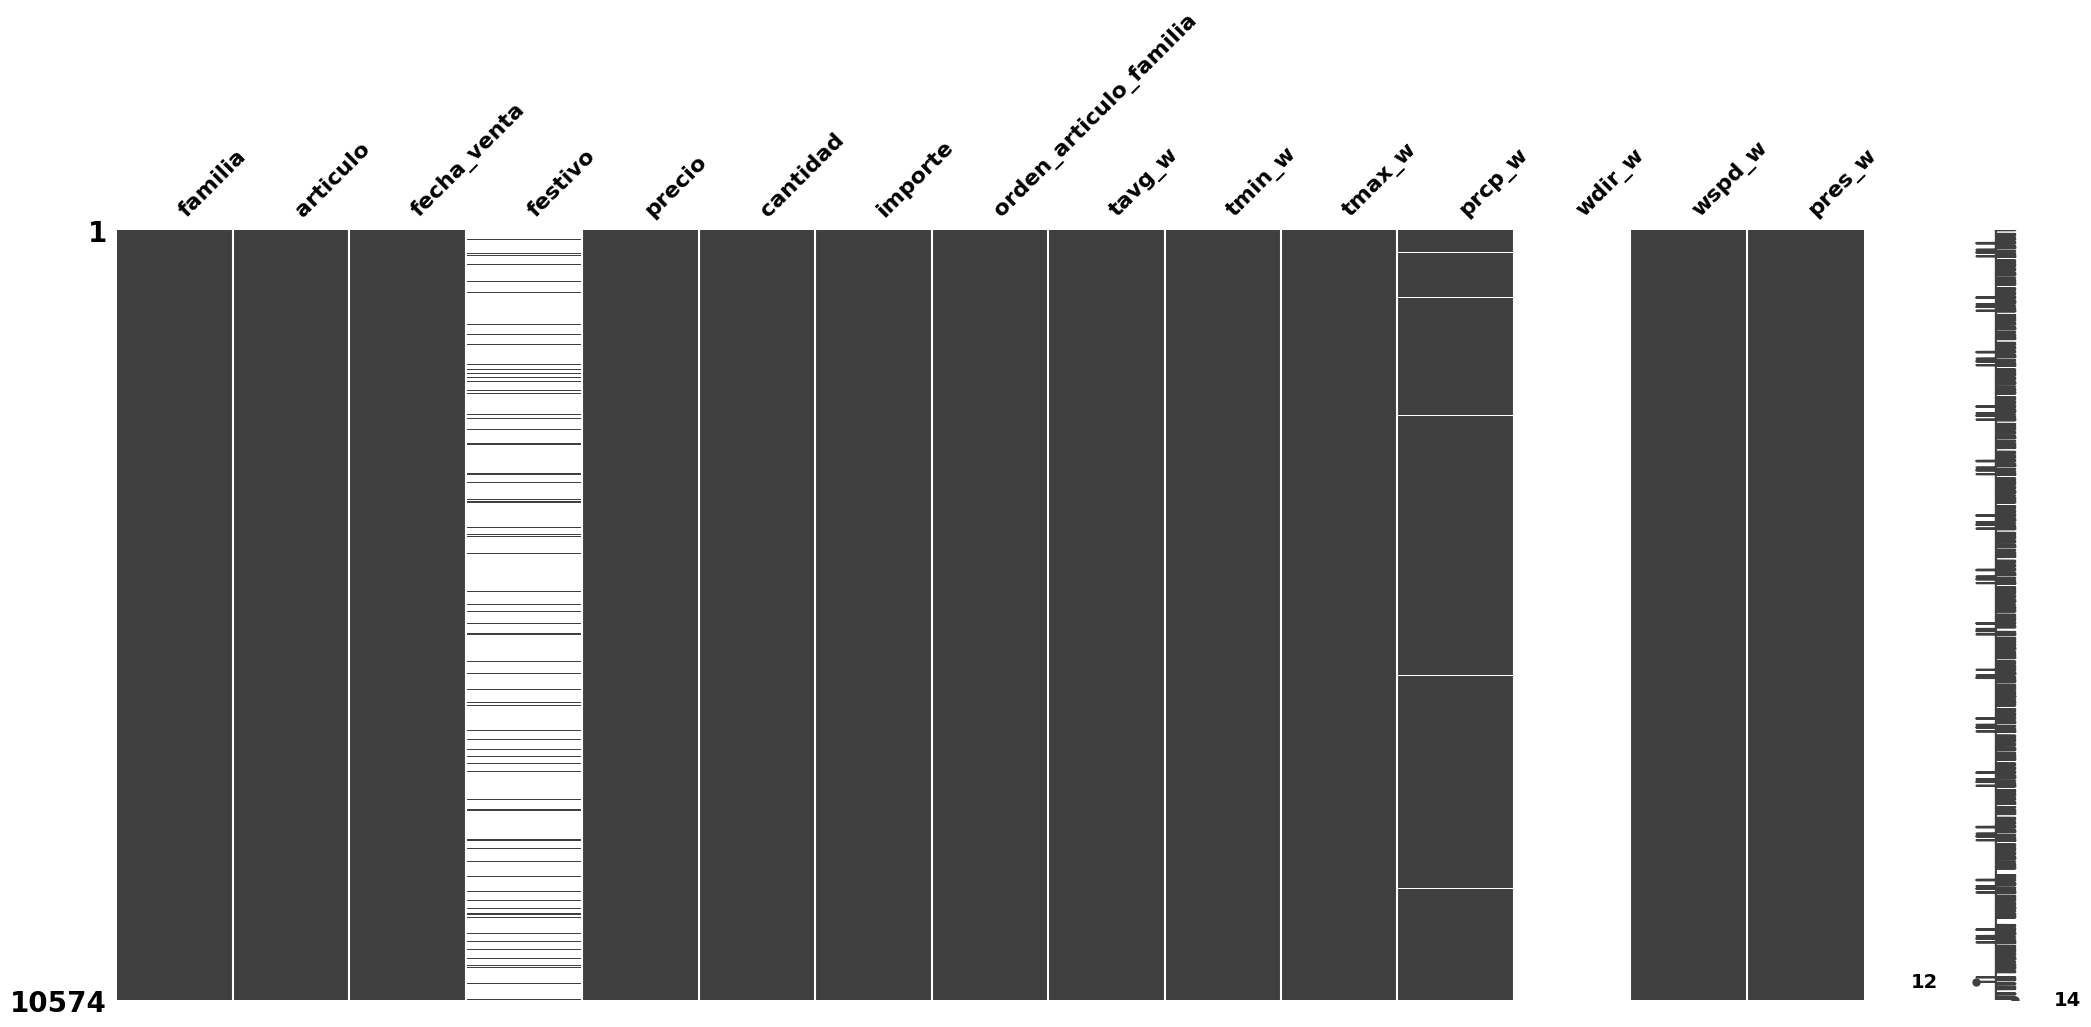

In [25]:
# 3_Gr√°fica visual de valores nulos, tengo que usar el m√©todo .to_pandas
msno.matrix(df.to_pandas())

In [26]:
# 4_Vamos a comprobar si hay duplicados
num_duplicated = df.is_duplicated().sum()
print(f"N√∫mero de filas duplicadas: {num_duplicated}")

N√∫mero de filas duplicadas: 0


In [27]:
# 4_Encuentra duplicados por varias columnas en Polars (sin argumento 'subset', solo los nombres de columnas)
# Creo una columna temporal que concatene fecha_venta y articulo
# Me est√° dando bastante problemas Polars
df_ext = df.with_columns(
    (pl.col("fecha_venta").cast(pl.Utf8) + "_" + pl.col("articulo").cast(pl.Utf8)).alias("fecha_articulo")
)

# Busco duplicados de la columna
duplicated_mask = df_ext["fecha_articulo"].is_duplicated()
# Filtro para ver solo las filas duplicadas
df_double = df_ext.filter(duplicated_mask)

# Visualizo sin la columna temporal
print(df_double.drop("fecha_articulo"))


shape: (0, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---     ‚îÜ ---      ‚îÜ ---         ‚îÜ ---     ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ str     ‚îÜ i64      ‚îÜ date        ‚îÜ str     ‚îÜ   ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ

Al buscar filas duplicadas por las columnas "fecha_venta" y "articulo", el DataFrame resultante est√° vac√≠o. Por tanto, podemos afirmar que no existen duplicados para esta combinaci√≥n de claves.


In [28]:
# Voy a definir los tipos n√∫mericos, ya que polars no tiene el m√©todo "is_numeric_dtype"

# (Me estoy empezando a arrepentir de usar Polars)

# Num. types
numeric_types = [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]

# Pruebo la definici√≥n
numeric_cols = [col for col in df.columns if df[col].dtype in numeric_types]
df.select(numeric_cols).describe()

shape: (9, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ articulo   ‚îÜ precio    ‚îÜ cantidad  ‚îÜ ‚Ä¶ ‚îÜ prcp_w   ‚îÜ wdir_w  ‚îÜ wspd_w    ‚îÜ pres_w    ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ   ‚îÜ ---      ‚îÜ ---     ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ str        ‚îÜ f64        ‚îÜ f64       ‚îÜ f64       ‚îÜ   ‚îÜ f64      ‚îÜ f64     ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 10574.0    ‚îÜ 10574.0   ‚îÜ 10574.0   ‚îÜ ‚Ä¶ ‚îÜ 10477.0  ‚îÜ 0.0     ‚îÜ 10574.0   ‚îÜ 10574.0   ‚îÇ
‚îÇ null_count ‚îÜ 0.0        ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ ‚Ä¶ ‚îÜ 97.0     ‚îÜ 10574.0 ‚îÜ 0.0       ‚îÜ 0.0       ‚îÇ
‚îÇ mean       ‚îÜ 3945.09173 ‚îÜ 15.414053 ‚îÜ 1514.5674 ‚îÜ ‚Ä¶ ‚îÜ 0.793118 ‚îÜ null    ‚îÜ 14.323492 ‚îÜ 1018.0159 ‚îÇ
‚îÇ            ‚îÜ 4          ‚îÜ           ‚îÜ 85        ‚îÜ   ‚îÜ          ‚îÜ         ‚îÜ           ‚îÜ 92        ‚îÇ
‚îÇ std        ‚îÜ 2404.63037 ‚îÜ 17.003998 ‚îÜ 1629.8102 ‚îÜ ‚Ä¶ ‚îÜ 4.279853 ‚îÜ null    ‚îÜ 5.313389  ‚îÜ 5.113184  ‚îÇ
‚îÇ            ‚îÜ 3          ‚îÜ           ‚îÜ 79        ‚îÜ   ‚îÜ          ‚îÜ         ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ min        ‚îÜ 417.0      ‚îÜ 0.865     ‚îÜ 13.200001 ‚îÜ ‚Ä¶ ‚îÜ 0.0      ‚îÜ null    ‚îÜ 6.1       ‚îÜ 1004.4    ‚îÇ
‚îÇ 25%        ‚îÜ 1043.0     ‚îÜ 2.591     ‚îÜ 165.0     ‚îÜ ‚Ä¶ ‚îÜ 0.0      ‚îÜ null    ‚îÜ 10.9      ‚îÜ 1014.5    ‚îÇ
‚îÇ 50%        ‚îÜ 5403.0     ‚îÜ 3.545     ‚îÜ 924.0     ‚îÜ ‚Ä¶ ‚îÜ 0.0      ‚îÜ null    ‚îÜ 12.5      ‚îÜ 1017.2    ‚îÇ
‚îÇ 75%        ‚îÜ 6286.0     ‚îÜ 34.091    ‚îÜ 2409.0    ‚îÜ ‚Ä¶ ‚îÜ 0.0      ‚îÜ null    ‚îÜ 16.8      ‚îÜ 1021.0    ‚îÇ
‚îÇ max        ‚îÜ 6549.0     ‚îÜ 43.5      ‚îÜ 12210.0   ‚îÜ ‚Ä¶ ‚îÜ 46.8     ‚îÜ null    ‚îÜ 46.5      ‚îÜ 1032.8    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [29]:
# Resumen de los datos, he necesitado pasarlo todo a String, si no daba error ya que Polars es bastante exigente con los tipos


summary_dict = {
    "Columna": [str(col) for col in df.columns],
    "Tipo": [str(df[col].dtype) for col in df.columns],
    "Cardinalidad": [str(df[col].n_unique()) for col in df.columns],
    "Granularidad (%)": [str(round(df[col].n_unique() / df.height * 100, 2)) for col in df.columns],
    "Nulos_Pct (%)": [str(round(df[col].null_count() /df.height * 100, 2)) for col in df.columns],
    "Max": [str(df[col].max()) if df[col].dtype in numeric_types else None for col in df.columns],
    "Min": [str(df[col].min()) if df[col].dtype in numeric_types else None for col in df.columns]
}

summary = pl.DataFrame(summary_dict)

summary

shape: (15, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ Columna     ‚îÜ Tipo    ‚îÜ Cardinalidad ‚îÜ Granularidad    ‚îÜ Nulos_Pct (%) ‚îÜ Max    ‚îÜ Min            ‚îÇ
‚îÇ ---         ‚îÜ ---     ‚îÜ ---          ‚îÜ (%)             ‚îÜ ---           ‚îÜ ---    ‚îÜ ---            ‚îÇ
‚îÇ str         ‚îÜ str     ‚îÜ str          ‚îÜ ---             ‚îÜ str           ‚îÜ str    ‚îÜ str            ‚îÇ
‚îÇ             ‚îÜ         ‚îÜ              ‚îÜ str             ‚îÜ               ‚îÜ        ‚îÜ                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ familia     ‚îÜ String  ‚îÜ 3            ‚îÜ 0.03            ‚îÜ 0.0           ‚îÜ null   ‚îÜ null           ‚îÇ
‚îÇ articulo    ‚îÜ Int64   ‚îÜ 15           ‚îÜ 0.14            ‚îÜ 0.0           ‚îÜ 6549   ‚îÜ 417            ‚îÇ
‚îÇ fecha_venta ‚îÜ Date    ‚îÜ 748          ‚îÜ 7.07            ‚îÜ 0.0           ‚îÜ null   ‚îÜ null           ‚îÇ
‚îÇ festivo     ‚îÜ String  ‚îÜ 27           ‚îÜ 0.26            ‚îÜ 92.08         ‚îÜ null   ‚îÜ null           ‚îÇ
‚îÇ precio      ‚îÜ Float64 ‚îÜ 92           ‚îÜ 0.87            ‚îÜ 0.0           ‚îÜ 43.5   ‚îÜ 0.865000009536 ‚îÇ
‚îÇ             ‚îÜ         ‚îÜ              ‚îÜ                 ‚îÜ               ‚îÜ        ‚îÜ 7432           ‚îÇ
‚îÇ ‚Ä¶           ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶               ‚îÜ ‚Ä¶             ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶              ‚îÇ
‚îÇ tmax_w      ‚îÜ Float64 ‚îÜ 221          ‚îÜ 2.09            ‚îÜ 0.0           ‚îÜ 42.6   ‚îÜ 13.3           ‚îÇ
‚îÇ prcp_w      ‚îÜ Float64 ‚îÜ 60           ‚îÜ 0.57            ‚îÜ 0.92          ‚îÜ 46.8   ‚îÜ 0.0            ‚îÇ
‚îÇ wdir_w      ‚îÜ Float64 ‚îÜ 1            ‚îÜ 0.01            ‚îÜ 100.0         ‚îÜ None   ‚îÜ None           ‚îÇ
‚îÇ wspd_w      ‚îÜ Float64 ‚îÜ 197          ‚îÜ 1.86            ‚îÜ 0.0           ‚îÜ 46.5   ‚îÜ 6.1            ‚îÇ
‚îÇ pres_w      ‚îÜ Float64 ‚îÜ 217          ‚îÜ 2.05            ‚îÜ 0.0           ‚îÜ 1032.8 ‚îÜ 1004.4         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

**Grupo de preguntas 2** (x minutos):

5. ¬øCu√°l es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¬øhay fechas faltantes? Crea un gr√°fico de evoluci√≥n temporal para la variable "cantidad" que muestre el producto "6549".

6. Separando por producto, ¬øhay outliers en la variable "cantidad"?

In [30]:
# 5_Recordar rango de fechas
print(df["fecha_venta"].min(), df["fecha_venta"].max())

print(f"Fecha m√≠nima: {df['fecha_venta'].min()}")
print(f"Fecha m√°xima: {df['fecha_venta'].max()}")



2021-05-01 2023-05-18
Fecha m√≠nima: 2021-05-01
Fecha m√°xima: 2023-05-18


In [31]:
# Comprobar si hay fechas faltantes por producto

all_dates = pl.date_range(
    start=df["fecha_venta"].min(),
    end=df["fecha_venta"].max(),
    interval="1d",
    eager=True
)

# Funci√≥n para ver fechas faltantes para cada producto
id_product = 6549
product_date = df.filter(pl.col("articulo") == id_product)["fecha_venta"].unique()
missing_date = set(all_dates.to_list()) - set(product_date.to_list())

print(f"Fechas faltantes para el producto {id_product}:")
print(sorted(missing_date))
print(f"Total d√≠as sin datos: {len(missing_date)}")




Fechas faltantes para el producto 6549:
[datetime.date(2021, 5, 3), datetime.date(2021, 5, 4), datetime.date(2021, 5, 5), datetime.date(2021, 5, 6), datetime.date(2021, 5, 10), datetime.date(2021, 5, 11), datetime.date(2021, 5, 18), datetime.date(2021, 5, 19), datetime.date(2021, 5, 20), datetime.date(2021, 5, 25), datetime.date(2021, 5, 26), datetime.date(2021, 6, 1), datetime.date(2021, 6, 2), datetime.date(2021, 6, 7), datetime.date(2021, 6, 8), datetime.date(2021, 6, 10), datetime.date(2021, 6, 15), datetime.date(2021, 6, 16), datetime.date(2021, 6, 17), datetime.date(2021, 7, 1), datetime.date(2021, 7, 8), datetime.date(2021, 7, 12), datetime.date(2021, 7, 13), datetime.date(2021, 7, 14), datetime.date(2021, 7, 19), datetime.date(2021, 7, 22), datetime.date(2021, 7, 28), datetime.date(2021, 7, 29), datetime.date(2021, 8, 2), datetime.date(2021, 8, 3), datetime.date(2021, 8, 4), datetime.date(2021, 8, 5), datetime.date(2021, 8, 17), datetime.date(2021, 8, 18), datetime.date(2021, 8

In [32]:
# Hecha la anterior celda, con la funci√≥n para un producto, har√© la funci√≥n para todos los productos
full_dates = pl.date_range(
    start=df["fecha_venta"].min(),
    end=df["fecha_venta"].max(),
    interval="1d",
    eager=True
).to_list()

# Lista de productos √∫nicos
products = df["articulo"].unique().to_list()

# Dict para guardar fechas faltantes
missing_dates = {}

for prod in products:
    prod_dates = df.filter(pl.col("articulo") == prod)["fecha_venta"].unique().to_list()
    missing = sorted(set(full_dates) - set(prod_dates))
    if missing:  # Solo deber√≠a guardar si faltan fechas
        missing_dates[prod] = missing

# Muestra resultado resumido
print(f"Productos con fechas faltantes: {len(missing_dates)} de {len(products)} productos\n")
for prod, missing in missing_dates.items():
    print(f"Producto {prod}: {len(missing)} fechas faltantes")




Productos con fechas faltantes: 8 de 15 productos

Producto 5403: 107 fechas faltantes
Producto 5404: 98 fechas faltantes
Producto 5803: 3 fechas faltantes
Producto 6286: 2 fechas faltantes
Producto 6425: 1 fechas faltantes
Producto 6451: 74 fechas faltantes
Producto 6523: 49 fechas faltantes
Producto 6549: 312 fechas faltantes


In [33]:
# Para ver fechas concretas para cada uno
example = list(missing_dates.keys())[0] if missing_dates else None
if example:
    print(f"\nFechas faltantes para el producto {example}:")
    print(missing_dates[example])


Fechas faltantes para el producto 5403:
[datetime.date(2021, 5, 13), datetime.date(2021, 5, 19), datetime.date(2021, 5, 25), datetime.date(2021, 5, 27), datetime.date(2021, 6, 2), datetime.date(2021, 6, 15), datetime.date(2021, 6, 17), datetime.date(2021, 6, 29), datetime.date(2021, 7, 7), datetime.date(2021, 7, 20), datetime.date(2021, 8, 3), datetime.date(2021, 8, 12), datetime.date(2021, 8, 13), datetime.date(2021, 10, 13), datetime.date(2021, 10, 25), datetime.date(2021, 10, 27), datetime.date(2021, 11, 8), datetime.date(2021, 11, 18), datetime.date(2021, 11, 23), datetime.date(2021, 11, 25), datetime.date(2021, 12, 2), datetime.date(2021, 12, 9), datetime.date(2021, 12, 12), datetime.date(2021, 12, 14), datetime.date(2021, 12, 15), datetime.date(2022, 1, 5), datetime.date(2022, 1, 6), datetime.date(2022, 1, 7), datetime.date(2022, 1, 18), datetime.date(2022, 1, 28), datetime.date(2022, 2, 2), datetime.date(2022, 2, 9), datetime.date(2022, 2, 14), datetime.date(2022, 2, 15), datet

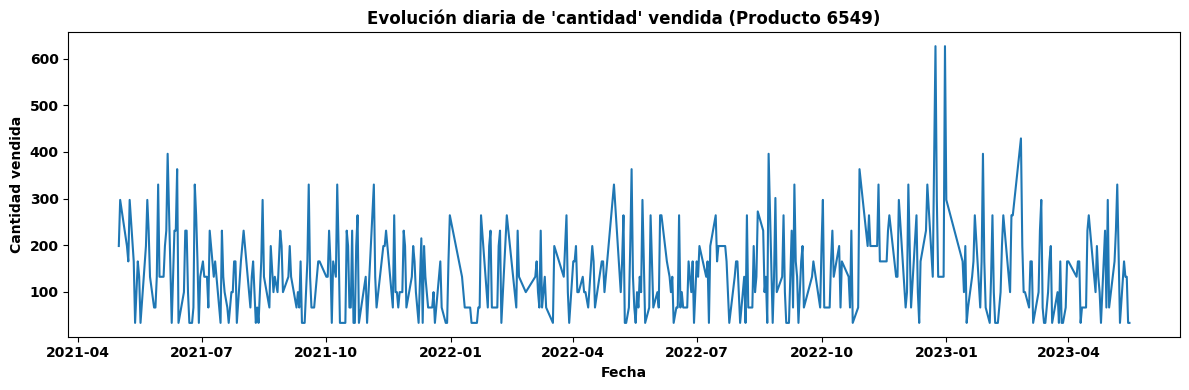

In [34]:
PLOTS_EDA_DIR = r"d:\PersonalProjects\Panader√≠a Datathon\outputs\plots"

# Gr√°fico de evoluci√≥n temporal para el producto 6549

# Filtro datos del producto y los ordeno por fecha
df_6549 = df.filter(pl.col("articulo") == 6549).sort("fecha_venta")

# Ploteo
plt.figure(figsize=(12, 4))
plt.plot(df_6549["fecha_venta"].to_pandas(), df_6549["cantidad"].to_pandas())
plt.title("Evoluci√≥n diaria de 'cantidad' vendida (Producto 6549)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "daily_evolution_sold_6549"))
plt.show()

In [35]:
# 6_Outliers, calculo Q1, Q3, IQR
q1 = df_6549["cantidad"].quantile(0.25)
q3 = df_6549["cantidad"].quantile(0.75)
iqr = q3 - q1
lim_sup = q3 + 1.5 * iqr
lim_inf = q1 - 1.5 * iqr

# Filtrar outliers
outliers_6549 = df_6549.filter(
    (pl.col("cantidad") < lim_inf) | (pl.col("cantidad") > lim_sup)
)

print(f"N√∫mero de outliers para el producto 6549: {outliers_6549.shape[0]}")
outliers_6549

N√∫mero de outliers para el producto 6549: 3


shape: (3, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia    ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo    ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---         ‚îÜ ---        ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ str        ‚îÜ i64      ‚îÜ date        ‚îÜ str        ‚îÜ   ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ PASTELERIA ‚îÜ 6549     ‚îÜ 2022-12-24  ‚îÜ Nochebuena ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 10.5   ‚îÜ 1023.3 ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6549     ‚îÜ 2022-12-31  ‚îÜ Nochevieja ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.4   ‚îÜ 1027.2 ‚îÇ
‚îÇ PASTELERIA ‚îÜ 6549     ‚îÜ 2023-02-25  ‚îÜ null       ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 11.5   ‚îÜ 1009.2 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

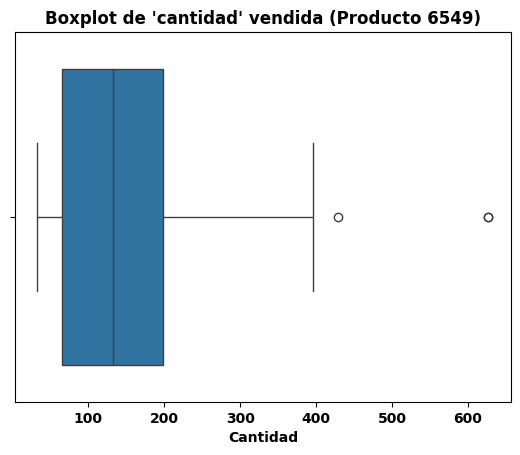

In [36]:
# Boxplot para ver outliers, hay que pasarlo a pandas tambi√©n
import seaborn as sns

sns.boxplot(x=df_6549["cantidad"].to_pandas())
plt.title("Boxplot de 'cantidad' vendida (Producto 6549)")
plt.xlabel("Cantidad")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "boxplot_6549"), dpi=300)
plt.show()




In [37]:
# Mostramos valores de esos outliers
print(outliers_6549[["fecha_venta", "cantidad"]])

shape: (3, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ fecha_venta ‚îÜ cantidad ‚îÇ
‚îÇ ---         ‚îÜ ---      ‚îÇ
‚îÇ date        ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2022-12-24  ‚îÜ 627.0    ‚îÇ
‚îÇ 2022-12-31  ‚îÜ 627.0    ‚îÇ
‚îÇ 2023-02-25  ‚îÜ 429.0    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


In [38]:
# Vamos a intentar hacer una funci√≥n que detecte todos los outliers del dataset

def get_outliers_product(df, columna_producto="articulo", columna_valor="cantidad"):
    outliers_list = []
    products = df[columna_producto].unique().to_list()

    for prod in products:
        subdf = df.filter(pl.col(columna_producto) == prod)
        if subdf.shape[0] < 5:
            continue   # Ignora productos con pocos datos

        q1 = subdf[columna_valor].quantile(0.25)
        q3 = subdf[columna_valor].quantile(0.75)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 - 1.5 * iqr

        outliers = subdf.filter((pl.col(columna_valor) < lim_inf) | (pl.col(columna_valor) > lim_sup))
        if outliers.shape[0] > 0:
            outliers_list.append(outliers)

    if outliers_list:
        return pl.concat(outliers_list)
    else:
        return pl.DataFrame([])
    
# Probamos la funci√≥n
all_outliers = get_outliers_product(df)
print(f"N√∫mero total de outliers en todo el dataset: {all_outliers.shape[0]}")
all_outliers.head()

N√∫mero total de outliers en todo el dataset: 9853


shape: (5, 15)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ familia   ‚îÜ articulo ‚îÜ fecha_venta ‚îÜ festivo         ‚îÜ ‚Ä¶ ‚îÜ prcp_w ‚îÜ wdir_w ‚îÜ wspd_w ‚îÜ pres_w ‚îÇ
‚îÇ ---       ‚îÜ ---      ‚îÜ ---         ‚îÜ ---             ‚îÜ   ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÜ ---    ‚îÇ
‚îÇ str       ‚îÜ i64      ‚îÜ date        ‚îÜ str             ‚îÜ   ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-01  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 14.2   ‚îÜ 1014.0 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-02  ‚îÜ D√≠a de la Madre ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 15.7   ‚îÜ 1015.9 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-03  ‚îÜ D√≠a de la Cruz  ‚îÜ ‚Ä¶ ‚îÜ 6.5    ‚îÜ null   ‚îÜ 9.7    ‚îÜ 1017.7 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-04  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 12.1   ‚îÜ 1018.0 ‚îÇ
‚îÇ PANADERIA ‚îÜ 417      ‚îÜ 2021-05-05  ‚îÜ null            ‚îÜ ‚Ä¶ ‚îÜ 0.0    ‚îÜ null   ‚îÜ 13.8   ‚îÜ 1016.5 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [39]:
# Porcentaje total de outliers en el dataset 
print(f"Porcentaje de outliers: {100 * all_outliers.shape[0] / df.shape[0]:.2f}%")


Porcentaje de outliers: 93.18%


### Sobre los outliers detectados en "cantidad"

Al aplicar el m√©todo cl√°sico de outliers (usando el rango intercuart√≠lico o IQR), hemos visto que m√°s del **90% de las observaciones** son marcadas como outliers. Esto no significa necesariamente que haya errores en los datos, sino que la distribuci√≥n de "cantidad" es **muy desigual**. En ventas reales es habitual encontrar:

- Muchos d√≠as con ventas cero (lo que estrecha el IQR).
- D√≠as puntuales con pedidos altos por promociones, eventos o simplemente variabilidad normal.
- Grandes diferencias entre productos (algunos con ventas constantes y otros casi nunca).

Por eso, el m√©todo IQR cl√°sico se vuelve **demasiado sensible** en este contexto y marca como outlier la mayor√≠a de las ventas.  
En estos casos, conviene revisar los datos visualmente y, si es necesario, ajustar el m√©todo (por ejemplo, usando un umbral m√°s amplio, percentiles, o solo revisando los casos extremos).

La mayor√≠a de estos "outliers" probablemente sean ventas v√°lidas y reflejan la realidad de los datos, no errores.**


In [40]:
# Tablas o dataframes generados, directorio
TABLES_DIR = r"d:\PersonalProjects\Panader√≠a Datathon\outputs\tables"

# Funci√≥n para contar outliers por producto (usando 1.5 x IQR)
def count_outliers_per_product(df, columna_producto="articulo", columna_valor="cantidad"):
    summary = []
    products = df[columna_producto].unique().to_list()
    for prod in products:
        subdf = df.filter(pl.col(columna_producto) == prod)
        if subdf.shape[0] < 5:
            continue
        q1 = subdf[columna_valor].quantile(0.25)
        q3 = subdf[columna_valor].quantile(0.75)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr
        n_outliers = subdf.filter((pl.col(columna_valor) < lim_inf) | (pl.col(columna_valor) > lim_sup)).shape[0]
        summary.append({"articulo": prod, "outliers_cantidad": n_outliers, "n_total": subdf.shape[0]})
    return pl.DataFrame(summary)

# Ejecuto y muestro la tabla
table_outliers = count_outliers_per_product(df)
table_outliers = table_outliers.with_columns(
    (pl.col("outliers_cantidad") / pl.col("n_total") * 100).alias("porcentaje_outliers")
)
table_outliers = table_outliers.sort("porcentaje_outliers", descending=True)

table_outliers.write_csv(os.path.join(TABLES_DIR, "outliers_productos.csv"))
print(table_outliers)


shape: (15, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ articulo ‚îÜ outliers_cantidad ‚îÜ n_total ‚îÜ porcentaje_outliers ‚îÇ
‚îÇ ---      ‚îÜ ---               ‚îÜ ---     ‚îÜ ---                 ‚îÇ
‚îÇ i64      ‚îÜ i64               ‚îÜ i64     ‚îÜ f64                 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 6286     ‚îÜ 59                ‚îÜ 746     ‚îÜ 7.908847            ‚îÇ
‚îÇ 5803     ‚îÜ 53                ‚îÜ 745     ‚îÜ 7.114094            ‚îÇ
‚îÇ 5403     ‚îÜ 37                ‚îÜ 641     ‚îÜ 5.772231            ‚îÇ
‚îÇ 6523     ‚îÜ 36                ‚îÜ 699     ‚îÜ 5.150215            ‚îÇ
‚îÇ 3880     ‚îÜ 38                ‚îÜ 748     ‚îÜ 5.080214            ‚îÇ

In [41]:
# Miro los 5 productos con mayor porcentaje de outliers
top_5_outliers = table_outliers.head(5)

print("Top 5 productos con mayor % de outliers en 'cantidad':")
print(top_5_outliers)


Top 5 productos con mayor % de outliers en 'cantidad':
shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ articulo ‚îÜ outliers_cantidad ‚îÜ n_total ‚îÜ porcentaje_outliers ‚îÇ
‚îÇ ---      ‚îÜ ---               ‚îÜ ---     ‚îÜ ---                 ‚îÇ
‚îÇ i64      ‚îÜ i64               ‚îÜ i64     ‚îÜ f64                 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 6286     ‚îÜ 59                ‚îÜ 746     ‚îÜ 7.908847            ‚îÇ
‚îÇ 5803     ‚îÜ 53                ‚îÜ 745     ‚îÜ 7.114094            ‚îÇ
‚îÇ 5403     ‚îÜ 37                ‚îÜ 641     ‚îÜ 5.772231            ‚îÇ
‚îÇ 6523     ‚îÜ 36                ‚îÜ 699     ‚îÜ 5.150215            ‚îÇ
‚îÇ 3880     ‚îÜ 38 

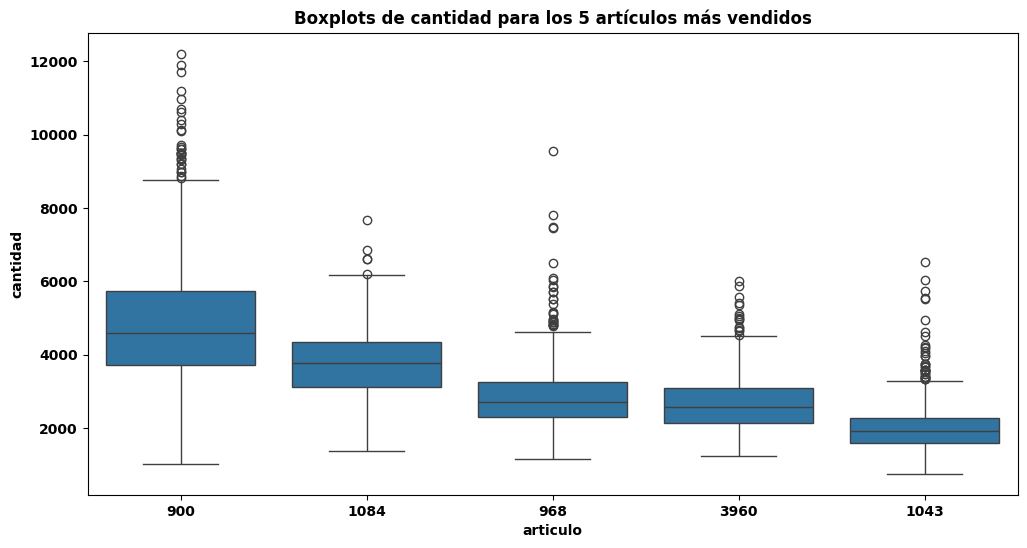

In [42]:
# Vamos a visualizar m√°s Boxplots para los productos top
top_items = df.group_by("articulo").agg(pl.col("cantidad").sum()).sort("cantidad", descending=True)["articulo"].to_list()[:5]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=pd.concat([df.filter(pl.col("articulo") == art).select(["cantidad"]).to_pandas().assign(articulo=str(art)) for art in top_items]),
    x="articulo",
    y="cantidad"
)
plt.title("Boxplots de cantidad para los 5 art√≠culos m√°s vendidos")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "outliers", "boxplots_outliers_top5_products"), dpi=300)
plt.show()

### Boxplot de cantidades para los 5 art√≠culos m√°s vendidos
El gr√°fico muestra la dispersi√≥n diaria de ventas para los cinco productos m√°s vendidos.
Se aprecian diferencias de escala y numerosos outliers, lo que indica d√≠as con ventas an√≥malamente altas.
Este an√°lisis ayuda a identificar variabilidad y detectar posibles anomal√≠as en los datos de ventas.

#### 4.2. An√°lisis de la variable a predecir

Este apartado tiene como cometido comprender la evoluci√≥n de la variable "cantidad" en el tiempo y como se relaciona esta consigo misma.

**Grupo de preguntas 3** (x minutos):

7. Crea un gr√°fico de la evoluci√≥n temporal general de la variable "cantidad". Nota: Se debe de agrupar.

8. Crea un gr√°fico de la evoluci√≥n temporal por familia de la variable "cantidad". Nota: Se debe de agrupar.

9. Crea un gr√°fico de la evoluci√≥n temporal por art√≠culo de la variable "cantidad". Nota: Se debe de agrupar.

10. Se que hay mucho ruido, pero ¬øa simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

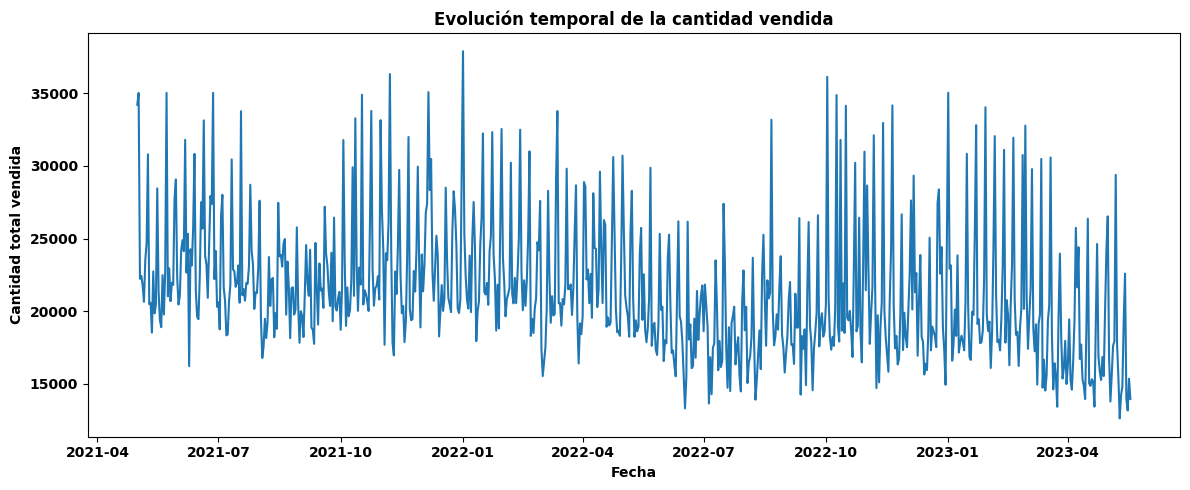

In [83]:
# 7_Evoluci√≥n temporal general de la variable "cantidad"

# Voy a agrupar por fecha y sumo la cantidad total vendida cada d√≠a
quantity_evo = (
    df.group_by("fecha_venta")
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort("fecha_venta")
)

# Paso a pandas para el plotting
plt.figure(figsize=(12, 5))
plt.plot(quantity_evo["fecha_venta"].to_pandas(), quantity_evo["cantidad_total"].to_pandas())
plt.title("Evoluci√≥n temporal de la cantidad vendida")
plt.xlabel("Fecha")
plt.ylabel("Cantidad total vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "total_quantity_sales"), dpi=300)
plt.show()

#### Evoluci√≥n temporal de la cantidad vendida

El gr√°fico muestra la evoluci√≥n diaria de la cantidad total vendida en la panader√≠a durante el periodo analizado.  
Se aprecia bastante ruido en las ventas diarias y no se observa una tendencia clara a simple vista, aunque podr√≠a haber patrones estacionales o picos puntuales.  
Este comportamiento es habitual en negocios minoristas, donde factores como la demanda variable o eventos especiales afectan la serie temporal.


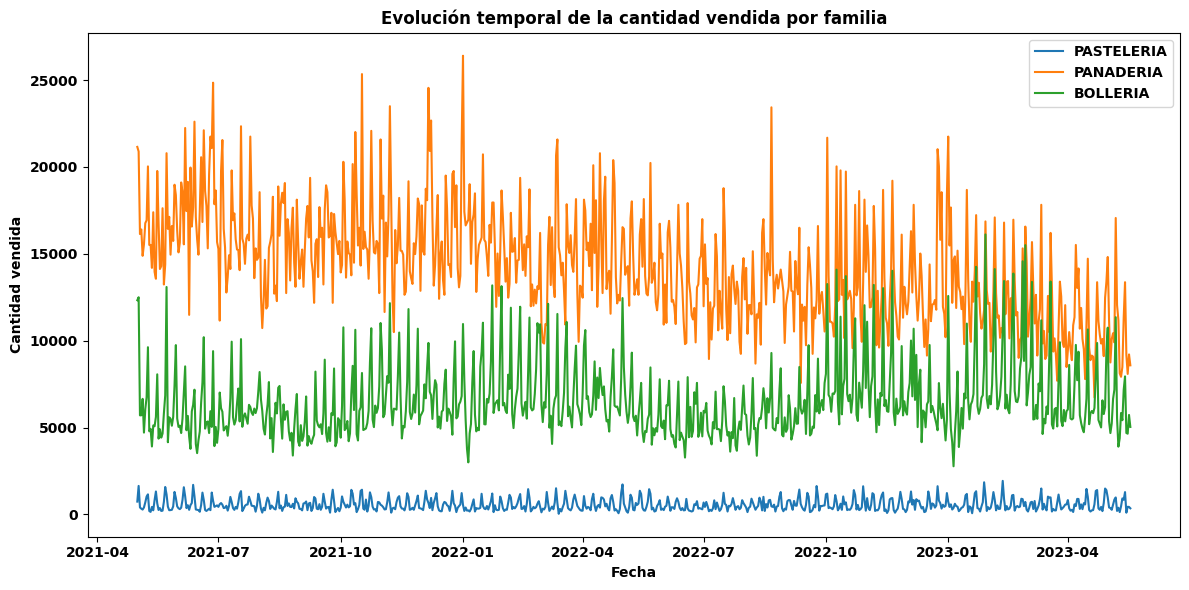

In [44]:
# 8_Evoluci√≥n temporal por familia de la variable "cantidad"

# Agrupar por fecha y familia
agg_familia = (
    df.group_by(["fecha_venta", "familia"])
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort(["familia", "fecha_venta"])
)

familias = agg_familia["familia"].unique().to_list()

plt.figure(figsize=(12, 6))
for fam in familias:
    data = agg_familia.filter(pl.col("familia") == fam)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), label=fam)
plt.title("Evoluci√≥n temporal de la cantidad vendida por familia")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_familia", "total_sales_per_family"), dpi=300)
plt.show()   

#### Evoluci√≥n temporal de la cantidad vendida por familia

La gr√°fica muestra c√≥mo evoluciona la cantidad total vendida a lo largo del tiempo para cada familia de productos.  
Se observan diferencias claras en el volumen y el comportamiento de ventas seg√∫n la familia, con algunas presentando m√°s variabilidad o picos en fechas concretas.  
Este an√°lisis ayuda a identificar patrones espec√≠ficos y posibles oportunidades de mejora para cada l√≠nea de producto.

Destaca especialmente la familia PANADER√çA, que muestra un volumen de ventas mucho mayor y una mayor estabilidad/picos a lo largo del tiempo, en comparaci√≥n con el resto de familias. Este comportamiento puede deberse a la popularidad del producto, promociones espec√≠ficas, una mayor demanda en ciertos periodos, o simplemente que son productos disponibles cada d√≠a, a excepci√≥n de otros de las dem√°s familias.


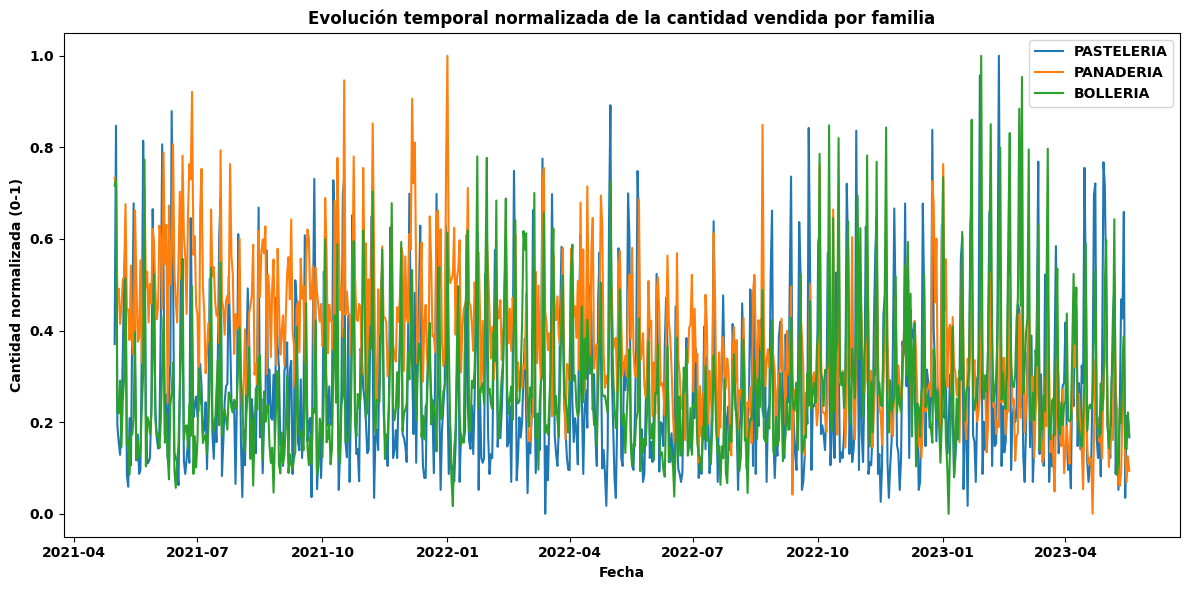

In [45]:
# Normalizamos la variable "cantidad", para una f√°cil comparaci√≥n aunque tengan escalas muy diferents las familias
from sklearn.preprocessing import MinMaxScaler

# Primero agrupamos por familia y fecha (como antes)
agg_familia = (
    df.group_by(["fecha_venta", "familia"])
      .agg(pl.col("cantidad").sum().alias("cantidad_total"))
      .sort(["familia", "fecha_venta"])
)

# Normaliza la cantidad para cada familia (0-1)
result = []
for fam in agg_familia["familia"].unique().to_list():
    sub = agg_familia.filter(pl.col("familia") == fam)
    scaler = MinMaxScaler()
    cantidades_norm = scaler.fit_transform(sub["cantidad_total"].to_numpy().reshape(-1,1)).flatten()
    temp_df = sub.with_columns([
        pl.Series("cantidad_norm", cantidades_norm)
    ])
    result.append(temp_df)

agg_norm = pl.concat(result)

# Plot
plt.figure(figsize=(12,6))
for fam in agg_norm["familia"].unique().to_list():
    datos = agg_norm.filter(pl.col("familia") == fam)
    plt.plot(datos["fecha_venta"].to_pandas(), datos["cantidad_norm"].to_pandas(), label=fam)
plt.title("Evoluci√≥n temporal normalizada de la cantidad vendida por familia")
plt.xlabel("Fecha")
plt.ylabel("Cantidad normalizada (0-1)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR,"eda_familia", "total_sales_scaler_per_family"), dpi=300)
plt.show()


#### Evoluci√≥n temporal normalizada de la cantidad vendida por familia

En este gr√°fico, la cantidad vendida por cada familia de productos se ha normalizado entre 0 y 1, para facilitar la comparaci√≥n de patrones y tendencias independientemente del volumen de ventas. 

La normalizaci√≥n permite observar similitudes o diferencias en la evoluci√≥n relativa de cada familia a lo largo del tiempo, destacando posibles efectos estacionales o comportamientos sincronizados entre productos.

> **Interpretaci√≥n de la evoluci√≥n temporal normalizada por familia:**  
> 
> Las tres familias (PASTELERIA, BOLLERIA y PANADERIA) presentan una evoluci√≥n diaria con mucha variabilidad y sin una tendencia clara a largo plazo.  
> No se observan picos sincronizados fuertes ni patrones de estacionalidad evidentes entre las familias: sus m√°ximos y m√≠nimos aparecen en fechas distintas.  
> La demanda parece estar influida m√°s por factores espec√≠ficos de cada producto que por patrones generales o estacionales.  
> En resumen, cada familia evoluciona de forma relativamente independiente y con bastante ruido d√≠a a d√≠a.



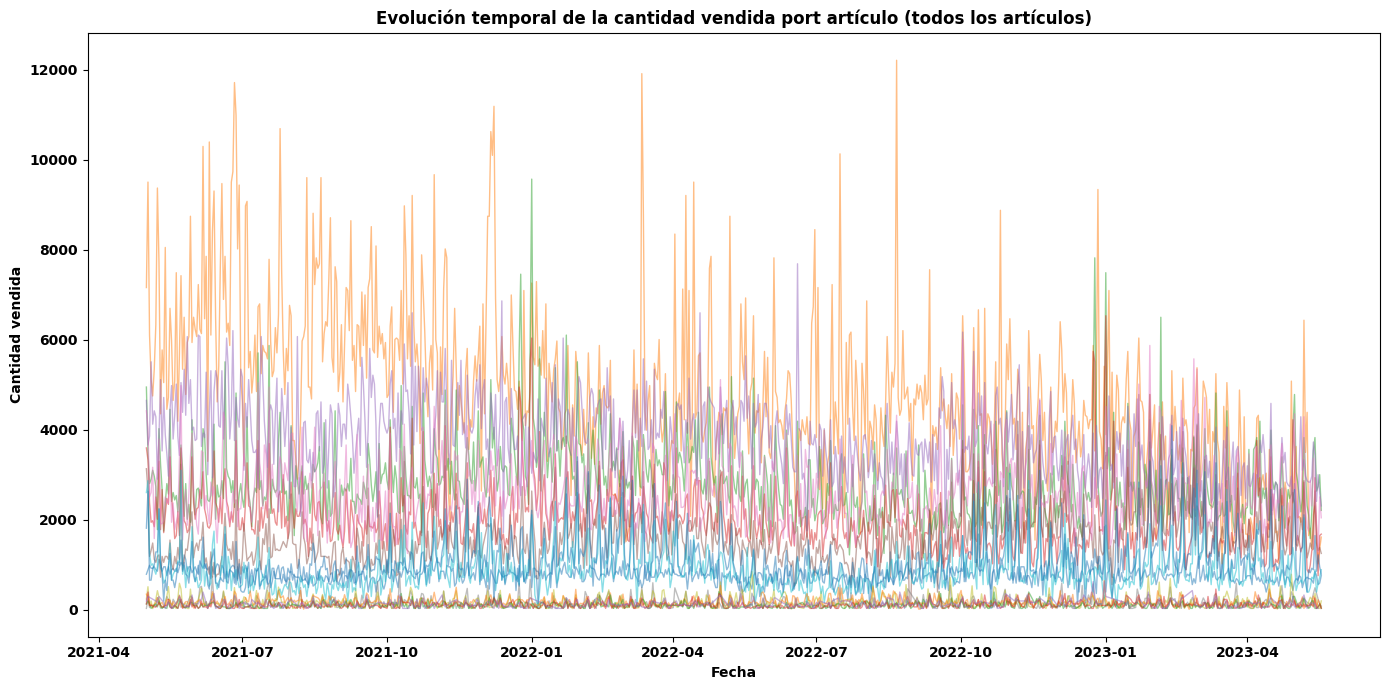

In [46]:
# 9_Evoluci√≥n temporal por art√≠culo de la variable "cantidad"

# Agrupar por fecha y art√≠culo
agg_articulos = (
    df.group_by(["fecha_venta", "articulo"])
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort(["articulo", "fecha_venta"])
)

# Art√≠culos √∫nicos
all_items = agg_articulos["articulo"].unique().to_list()

# Plotting
plt.figure(figsize=(14, 7))
for item in all_items:
    data = agg_articulos.filter(pl.col("articulo") == item)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), alpha=0.5, linewidth=1)
plt.title("Evoluci√≥n temporal de la cantidad vendida port art√≠culo (todos los art√≠culos)") 
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "total_sales_per_item"), dpi=300)
plt.show()



### Evoluci√≥n temporal de la cantidad vendida por art√≠culo

En este gr√°fico se representa la evoluci√≥n diaria de la cantidad vendida para **cada art√≠culo** del cat√°logo. Cada l√≠nea corresponde a un art√≠culo distinto.

Como era de esperar, el gr√°fico muestra un alto nivel de ruido visual debido al gran n√∫mero de art√≠culos representados, lo que hace que resulte dif√≠cil identificar patrones concretos para productos individuales. Sin embargo, esta visualizaci√≥n global es √∫til para hacerse una idea general del comportamiento conjunto, detectar picos generales de demanda o posibles anomal√≠as a nivel agregado.

> **Nota:** Por motivos de claridad, no se ha incluido una leyenda para cada art√≠culo, ya que har√≠a el gr√°fico ilegible. Para un an√°lisis m√°s detallado, es recomendable seleccionar art√≠culos concretos y analizar sus series de forma individual.


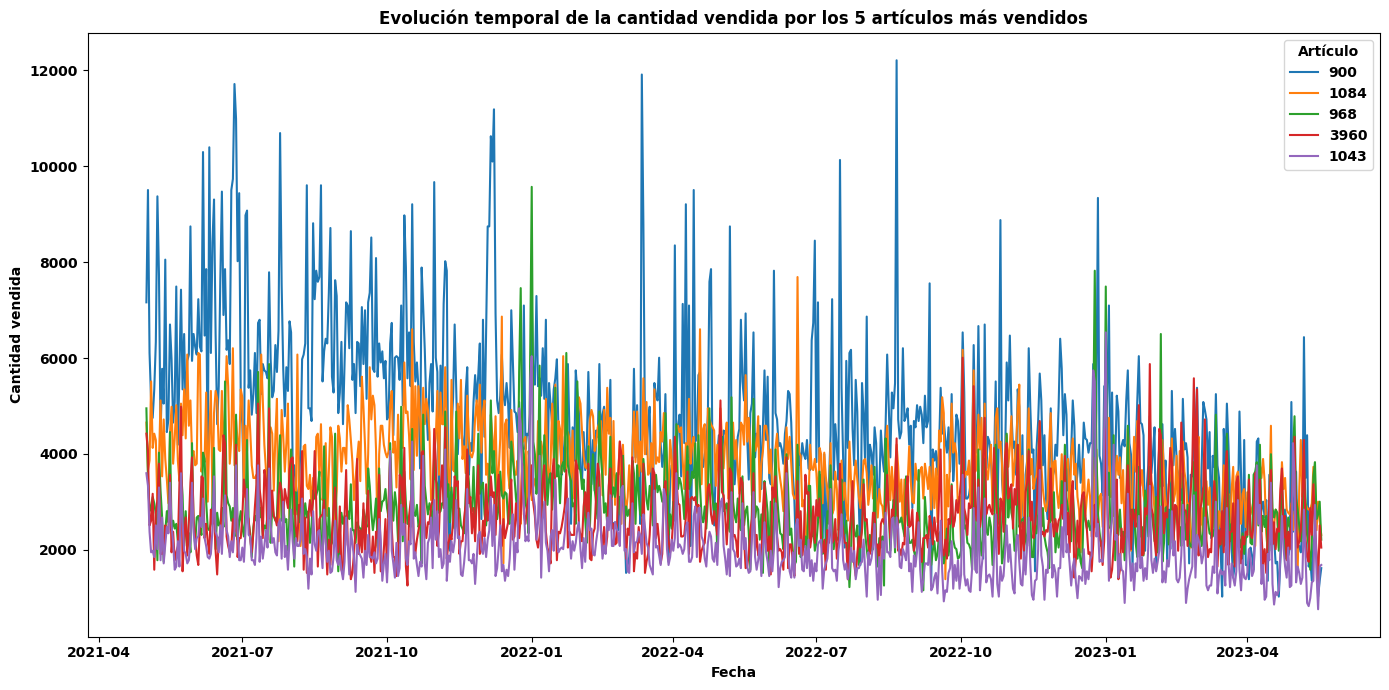

In [47]:
# Me voy a centrar en los art√≠culos m√°s vendidos para recibir un ploteo m√°s limpio

# Top 5 art√≠culos m√°s vendidos
best_five_items = (
    df.group_by("articulo")
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort("cantidad_total", descending=True)
    .head(5)["articulo"]
    .to_list()
)

# Filtro con art√≠culos top
df_top = df.filter(pl.col("articulo").is_in(best_five_items))

# Ploteo
plt.figure(figsize=(14, 7))
for item in best_five_items:
    data = agg_articulos.filter(pl.col("articulo") == item)
    plt.plot(data["fecha_venta"].to_pandas(), data["cantidad_total"].to_pandas(), label=str(item))
plt.title("Evoluci√≥n temporal de la cantidad vendida por los 5 art√≠culos m√°s vendidos")
plt.xlabel("Fecha")
plt.ylabel("Cantidad vendida")
plt.legend(title="Art√≠culo")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "total_sales_top5_items"), dpi=300)
plt.show()



### Evoluci√≥n temporal de la cantidad vendida para los 5 art√≠culos m√°s vendidos

Este gr√°fico muestra la evoluci√≥n diaria de la cantidad vendida para los cinco art√≠culos m√°s vendidos de la panader√≠a.

Cada l√≠nea representa un art√≠culo diferente, lo que permite comparar visualmente su comportamiento a lo largo del tiempo.  
Se observan **altos niveles de variabilidad** y picos pronunciados, lo que puede estar relacionado con la demanda estacional, promociones o eventos puntuales.

Este enfoque facilita detectar tendencias y posibles patrones para los productos m√°s relevantes, a diferencia del gr√°fico global donde el exceso de l√≠neas dificulta el an√°lisis detallado.


### 10. ¬øA simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

A simple vista, las series temporales analizadas muestran **mucho ruido** y una alta variabilidad diaria.  
No se aprecia una tendencia clara de aumento o descenso sostenido en la cantidad vendida para la mayor√≠a de productos o familias.

Sin embargo, **s√≠ parece haber cierta estacionalidad**: se observan repuntes y ca√≠das recurrentes en varios periodos, especialmente en los productos m√°s vendidos.  
Estas fluctuaciones podr√≠an estar asociadas a fines de semana, festivos, campa√±as especiales o √©pocas del a√±o concretas.

Para confirmar la presencia de tendencia o estacionalidad, ser√≠a recomendable aplicar t√©cnicas estad√≠sticas como la descomposici√≥n de series temporales o el an√°lisis de autocorrelaci√≥n.


**Grupo de preguntas 4** (x minutos):

11. Aplica alguna t√©cnica estad√≠stica para observar si hay estacionalidad en la evolucion temporal general de la variable "cantidad". Pista: Tomar la primera diferencia y, despu√©s, hacer un analisis de autocorrelaci√≥n.

12. Sin aplicar la primera diferencia y creando nuevas columnas de fecha a partir de la variable "fecha_venta" (semana del a√±o, mes del a√±o, d√≠a de la semana, d√≠a del mes, d√≠a del a√±o) comprueba realizando diferentes agrupaciones y gr√°ficos si nuestro an√°lisis de autocorrelaci√≥n de nuestra variable cantidad nos mostraba lo correcto. Si encuentras alg√∫n gr√°fico que te llame la atenci√≥n, baja el nivel del an√°lisis (Ej: 1. Cantidad general -> 2. Cantidad por familia -> 3. Cantidad por art√≠culo).

In [48]:
# 11_Test de estacionalidad (en Polars)
from statsmodels.tsa.stattools import adfuller

def check_stationarity_polars(df, date_col="fecha_venta", value_col="cantidad"):
    """
    Agrupar por d√≠a, sumar la columna value_col, y aplicar el test de Dickey-Fuller aumentado (ADF)
    """
    # Agrupar y sumar por fecha en Polars
    grouped = (
        df.group_by(date_col)
        .agg(pl.col(value_col).sum().alias("cantidad_total"))
        .sort(date_col)
    )
    # Pasar a una series de Panda para el test
    cantidad_pandas = grouped["cantidad_total"].to_pandas()

    # ADF
    result = adfuller(cantidad_pandas)
    print("ADF Statistic: ", result[0])
    print("p-value: ", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    if (result[1] <= 0.05) & (result[4]["5%"] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

# Probamos la funci√≥n
check_stationarity_polars(df, date_col="fecha_venta", value_col="cantidad")

ADF Statistic:  -1.4110271943456114
p-value:  0.5769782744361356
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
 Non-stationary 


<Figure size 800x500 with 0 Axes>

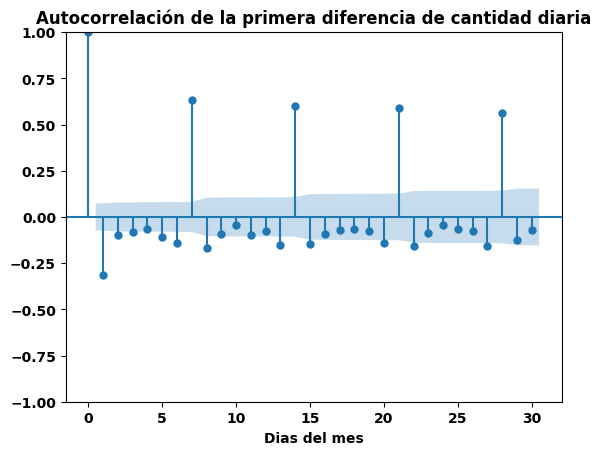

In [78]:
from statsmodels.graphics.tsaplots import plot_acf

# Agrupo la serie temporal general (cantidad total por d√≠a)
daily_serie = (
    df.group_by("fecha_venta")
    .agg(pl.col("cantidad").sum().alias("cantidad_total"))
    .sort("fecha_venta")
)

# Tomar la primera diferencia (numpy porqu√© tiene compatibilidad con statsmodels)
difference = daily_serie["cantidad_total"].to_numpy().astype(float)
first_dif = difference[1:] - difference[:-1]

# An√°lisis de autocorrelaci√≥n
plt.figure(figsize=(8, 5))
plot_acf(first_dif, lags=30)
plt.title("Autocorrelaci√≥n de la primera diferencia de cantidad diaria")
plt.xlabel("Dias del mes")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "autocorrelacion_primera_diferencia"), dpi=300)
plt.show()

#### ¬øHay estacionalidad en la evoluci√≥n temporal de la cantidad?

El gr√°fico de autocorrelaci√≥n de la primera diferencia de la cantidad diaria muestra **picos regulares y muy significativos en los rezagos 7, 14, 21, 28...**  
Esto indica claramente la presencia de **estacionalidad semanal**: las ventas siguen un patr√≥n recurrente cada 7 d√≠as, que probablemente corresponde al ciclo de la semana (efecto fin de semana, d√≠as laborales, etc.).

> El an√°lisis de autocorrelaci√≥n es una t√©cnica est√°ndar para detectar patrones repetitivos en series temporales, y en este caso confirma la estacionalidad sugerida por la visualizaci√≥n.

**Conclusi√≥n:**  
La serie temporal de cantidad diaria presenta una clara **estacionalidad semanal** (evidenciada por el gr√°fico de autocorrelaci√≥n) y, seg√∫n el test de Dickey-Fuller, **no es estacionaria** (p-valor alto).  
Por tanto, hay patrones repetitivos y cambios en la media o la varianza a lo largo del tiempo.



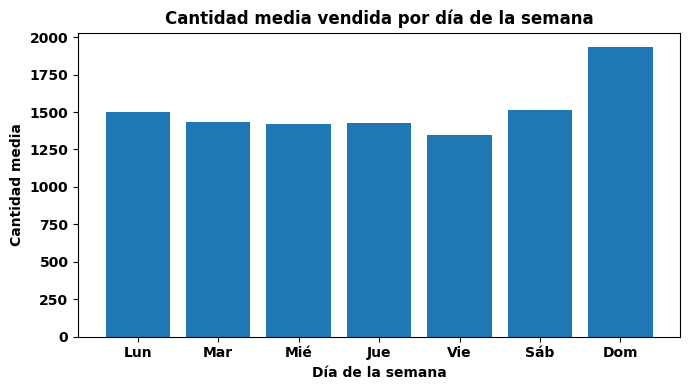

In [79]:
# 12_A√±adir columnas temporales al DataFrame
df = df.with_columns([
    pl.col("fecha_venta").dt.week().alias("semana_ano"),
    pl.col("fecha_venta").dt.month().alias("mes_ano"),
    pl.col("fecha_venta").dt.weekday().alias("dia_semana"),
    pl.col("fecha_venta").dt.day().alias("dia_mes"),
    pl.col("fecha_venta").dt.ordinal_day().alias("dia_ano"),
])

#  Agrupaci√≥n general por d√≠a de la semana
days = ["Lun", "Mar", "Mi√©", "Jue", "Vie", "S√°b", "Dom"]
agg_week = (
    df.group_by("dia_semana")
      .agg(pl.col("cantidad").mean().alias("cantidad_media"))
      .sort("dia_semana")
)

plt.figure(figsize=(7,4))
plt.bar([days[d-1] for d in agg_week["dia_semana"]], agg_week["cantidad_media"])
# En el plt.bar resto 1 d√≠a porqu√© he visto con un "print" que mis d√≠as van del 1 al 7, y deber√≠an ir del 0 al 6 y me daba error
plt.title("Cantidad media vendida por d√≠a de la semana")
plt.xlabel("D√≠a de la semana")
plt.ylabel("Cantidad media")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quantity_mean_weekday"), dpi=300)
plt.show()


Esto confirma la estacionalidad semanal que insinuaba el gr√°fico de autocorrelaci√≥n:

- Hay un patr√≥n claro de ventas m√°s altas en domingo.
- El resto de d√≠as est√°n bastante equilibrados, pero el viernes es el m√°s bajo.
- Esta informaci√≥n es muy √∫til para planificaci√≥n y previsi√≥n de stock.

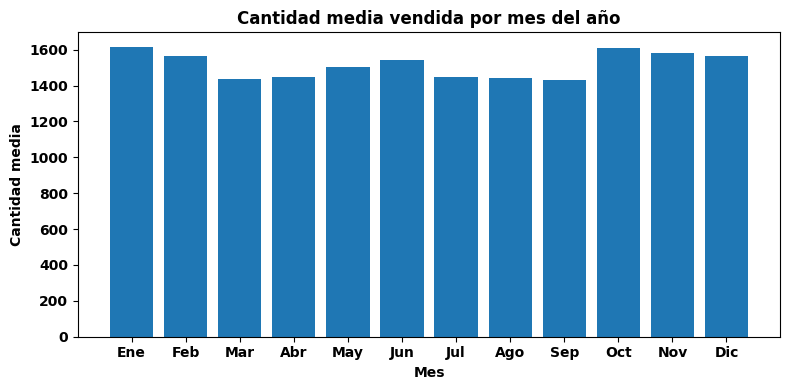

In [80]:
# Vamos a ver la cantidad media vendida por mes del a√±o

# Agrupar y calcular media
agg_month = (
    df.group_by("mes_ano")
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort("mes_ano")
)

# Meses
months = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]

# Plotting
plt.figure(figsize=(8,4))
plt.bar([months[m-1] for m in agg_month["mes_ano"]], agg_month["cantidad_media"])
plt.title("Cantidad media vendida por mes del a√±o")
plt.xlabel("Mes")
plt.ylabel("Cantidad media")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quantity_mean_month"), dpi=300)
plt.show()

No hay grandes diferencias extremas entre meses, pero se observa que enero, febrero, octubre y diciembre suelen tener valores m√°s altos de venta media.

Julio, agosto y septiembre son los meses con menos ventas, lo cual tiene sentido por posible efecto vacaciones o reducci√≥n de actividad estacional.

Hay cierta estacionalidad anual (m√°s ventas en invierno y final de a√±o, menos en verano).

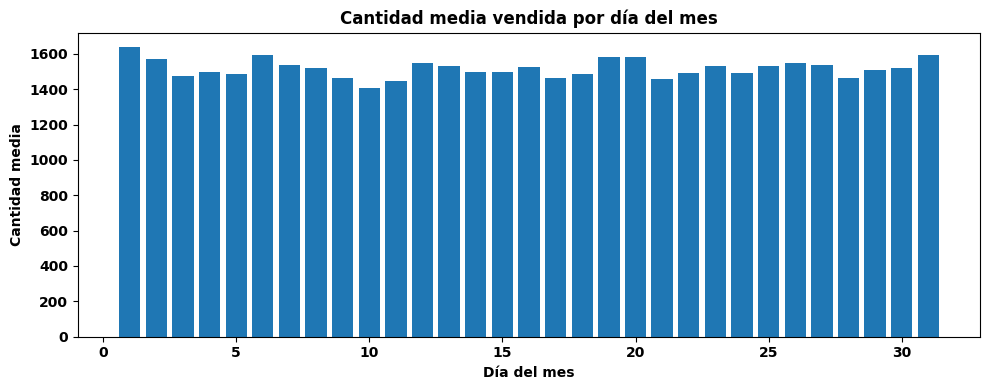

In [81]:
# Ahora la cantidad media por d√≠a del mes (1-30/31)

# Agrupar y calcular media
agg_monthday = (
    df.group_by("dia_mes")
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort("dia_mes")
)

# Plot
plt.figure(figsize=(10, 4))
plt.bar(agg_monthday["dia_mes"].to_list(), agg_monthday["cantidad_media"])
plt.title("Cantidad media vendida por d√≠a del mes")
plt.xlabel("D√≠a del mes")
plt.ylabel("Cantidad media")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quantity_mean_monthday"), dpi=300)
plt.show()

No se observan picos ni valles demasiado extremos; la cantidad media es bastante constante a lo largo del mes.

Se intuyen ligeros aumentos al principio y al final de mes, pero las diferencias no son muy pronunciadas.

Conclusi√≥n: No parece haber un patr√≥n fuerte de ventas asociado al d√≠a del mes, m√°s all√° de peque√±as variaciones aleatorias.

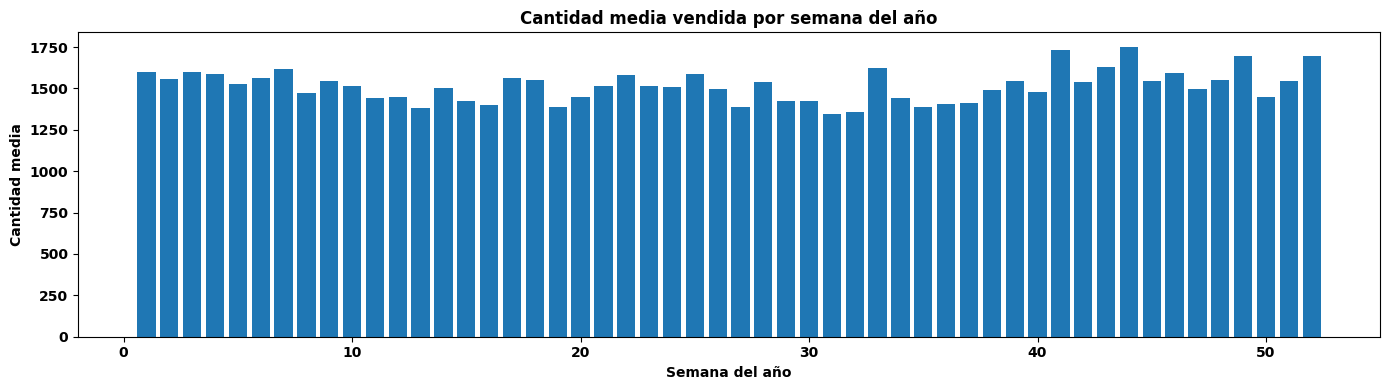

In [82]:
# Cantidad media vendida por semana del a√±o

# Agrupar y calcular media
agg_week_year = (
    df.group_by("semana_ano")
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort("semana_ano")
)

# Plotting
plt.figure(figsize=(14, 4))
plt.bar(agg_week_year["semana_ano"].to_list(), agg_week_year["cantidad_media"])
plt.title("Cantidad media vendida por semana del a√±o")
plt.xlabel("Semana del a√±o")
plt.ylabel("Cantidad media")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quantity_mean_weekyear"), dpi=300)
plt.show()

Se observa un comportamiento bastante estable durante la mayor parte del a√±o.

Sin embargo, hay picos al final del a√±o (alrededor de las semanas 40-52), lo que podr√≠a coincidir con temporadas festivas (Navidad, etc.).

Tambi√©n hay peque√±as subidas a lo largo del a√±o, pero no hay una estacionalidad clar√≠sima ni ca√≠das bruscas.

Conclusi√≥n: La venta media semanal es bastante homog√©nea, pero se intuye un aumento en la recta final del a√±o, probablemente por motivos estacionales o campa√±as.

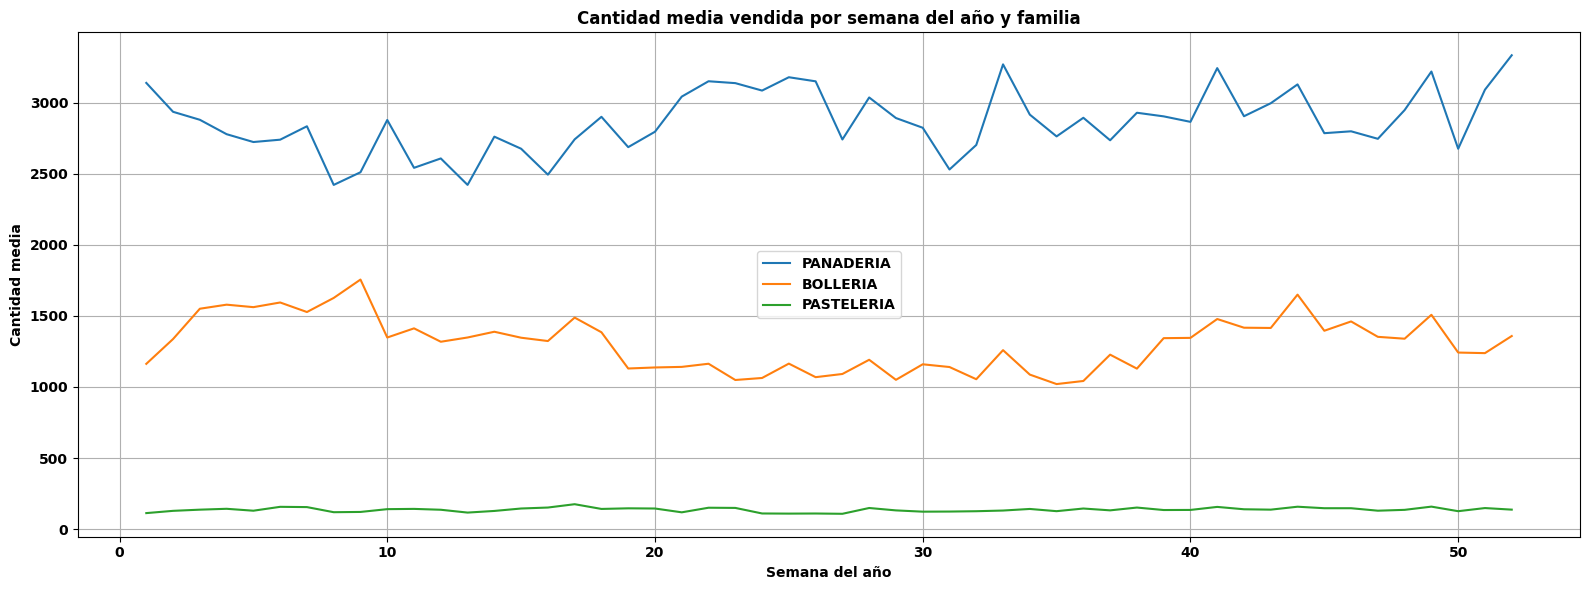

In [54]:
# Ahora vamos a ver la cantidad media vendida por familia, y por semana del a√±o, creo que es el periodo de tiempo m√°s espec√≠fico y claro

# Agrupar por semana del a√±o y familia
agg_week_family = (
    df.with_columns((pl.col("fecha_venta").dt.week()).alias("semana_ano"))
    .group_by(["semana_ano", "familia"])
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort(["familia", "semana_ano"])
)

# Obtener familias
families = agg_week_family["familia"].unique().to_list()

# Plot
plt.figure(figsize=(16, 6))
for fam in families:
    data = agg_week_family.filter(pl.col("familia") == fam)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), label=fam)
plt.title("Cantidad media vendida por semana del a√±o y familia")
plt.xlabel("Semana del a√±o")
plt.ylabel("Cantidad media")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_familia", "quantity_mean_byfamily"), dpi=300)
plt.show()  

## Evoluci√≥n semanal de la cantidad media vendida por familia

En el gr√°fico se representa la cantidad media vendida por semana a lo largo del a√±o para cada familia de productos: **PANADERIA**, **BOLLERIA** y **PASTELERIA**.

- **PANADERIA** es la familia con mayores ventas durante todo el a√±o y muestra una variabilidad notable, con algunos picos y valles que podr√≠an estar relacionados con estacionalidad, campa√±as o eventos concretos.
- **BOLLERIA** presenta un volumen de ventas intermedio y cierta oscilaci√≥n, aunque menos marcada que PANADERIA.
- **PASTELERIA** es la familia con menor volumen de ventas y su serie es m√°s estable, con menos fluctuaciones.

Se observan **patrones recurrentes** y cambios en las tendencias seg√∫n la semana del a√±o, lo que sugiere que existen factores estacionales o de demanda espec√≠ficos para cada familia de productos.

> **Observaci√≥n:** Ser√≠a recomendable, si se quiere profundizar, analizar semanas concretas donde se producen los picos o investigar si coinciden con festivos o campa√±as promocionales.



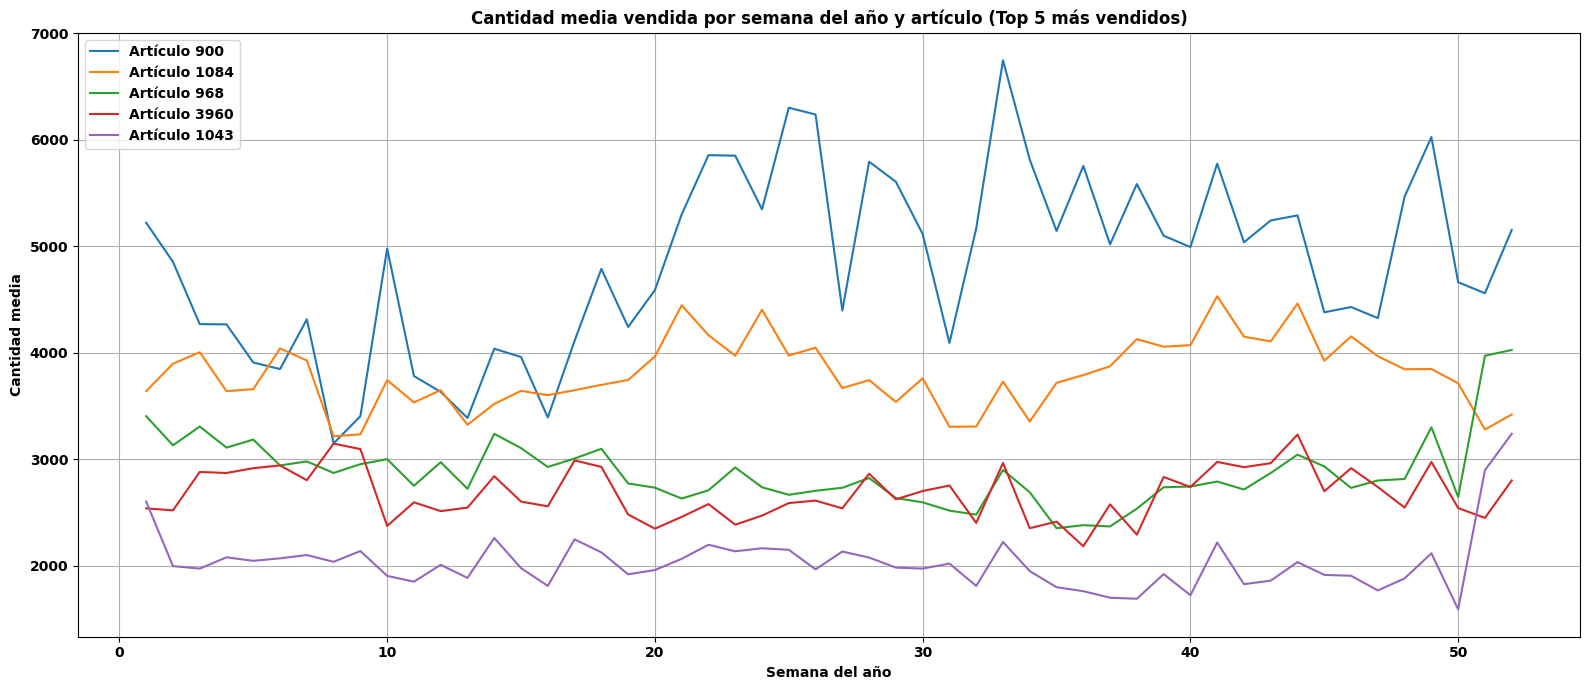

In [55]:
# No voy a graficar todos los art√≠culos porqu√© no se apreciaria nada, demasiado ruido

# As√≠ que vamos a ver los 5 art√≠culos m√°s vendidos por semana del a√±o

# Agregamos por semana y top art√≠culos

agg_week_article = (
    df.filter(pl.col("articulo").is_in(top_items))
    .group_by(["semana_ano", "articulo"])
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort(["articulo", "semana_ano"])
)

"""top_items lo teniamos definido anteriormente,
    d√≥nde nos muestra los 5 art√≠culos m√°s vendidos
    por cantidad dentro del a√±o natural."""

# Plotting
plt.figure(figsize=(16, 7))
for articulo in top_items:
    data = agg_week_article.filter(pl.col("articulo") == articulo)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), label=f"Art√≠culo {articulo}")
plt.title("Cantidad media vendida por semana del a√±o y art√≠culo (Top 5 m√°s vendidos)")
plt.xlabel("Semana del a√±o")
plt.ylabel("Cantidad media")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "quantity_mean_top5items"), dpi=300)
plt.show()  

### Evoluci√≥n semanal de la cantidad vendida ‚Äì Top 5 art√≠culos

El anterior gr√°fico muestra la evoluci√≥n de la cantidad media vendida por semana del a√±o para los cinco art√≠culos m√°s vendidos de la panader√≠a. Esta visualizaci√≥n permite observar tendencias, posibles estacionalidades y comparar el comportamiento entre los productos m√°s relevantes.

- **Interpretaci√≥n r√°pida:** Se aprecian ciertos picos y ca√≠das recurrentes, as√≠ como diferencias de volumen entre art√≠culos. Esto sugiere que algunos productos tienen temporadas altas bien definidas, mientras que otros mantienen un ritmo m√°s estable.
- **Utilidad:** Este tipo de an√°lisis ayuda a tomar decisiones sobre inventario, campa√±as promocionales y previsi√≥n de la demanda para los productos clave del negocio.


In [56]:
# Quiero hacer un an√°lisis extra para ver si los productos con m√°s outliers presentan m√°s estacionalidad

# Tenemos hecho con anterioridad:

print(top_5_outliers)

# Y la tabla de productos con los outliers:

print(table_outliers)



shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ articulo ‚îÜ outliers_cantidad ‚îÜ n_total ‚îÜ porcentaje_outliers ‚îÇ
‚îÇ ---      ‚îÜ ---               ‚îÜ ---     ‚îÜ ---                 ‚îÇ
‚îÇ i64      ‚îÜ i64               ‚îÜ i64     ‚îÜ f64                 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 6286     ‚îÜ 59                ‚îÜ 746     ‚îÜ 7.908847            ‚îÇ
‚îÇ 5803     ‚îÜ 53                ‚îÜ 745     ‚îÜ 7.114094            ‚îÇ
‚îÇ 5403     ‚îÜ 37                ‚îÜ 641     ‚îÜ 5.772231            ‚îÇ
‚îÇ 6523     ‚îÜ 36                ‚îÜ 699     ‚îÜ 5.150215            ‚îÇ
‚îÇ 3880     ‚îÜ 38                ‚îÜ 748     ‚îÜ 5.080214            ‚îÇ


In [57]:
# Productos m√°s problem√°ticos: top_5_outliers. Dejaremos con el mismo dtype
top_5_problematics = table_outliers.sort("porcentaje_outliers", descending=True).head(5)["articulo"].to_list()

# Productos m√°s estables
top_5_stables = table_outliers.sort("porcentaje_outliers").head(5)["articulo"].to_list()

print("Top 5 problem√°ticos:", top_5_problematics)
print("Top 5 estables:", top_5_stables)

Top 5 problem√°ticos: [6286, 5803, 5403, 6523, 3880]
Top 5 estables: [1084, 6549, 3960, 417, 6425]


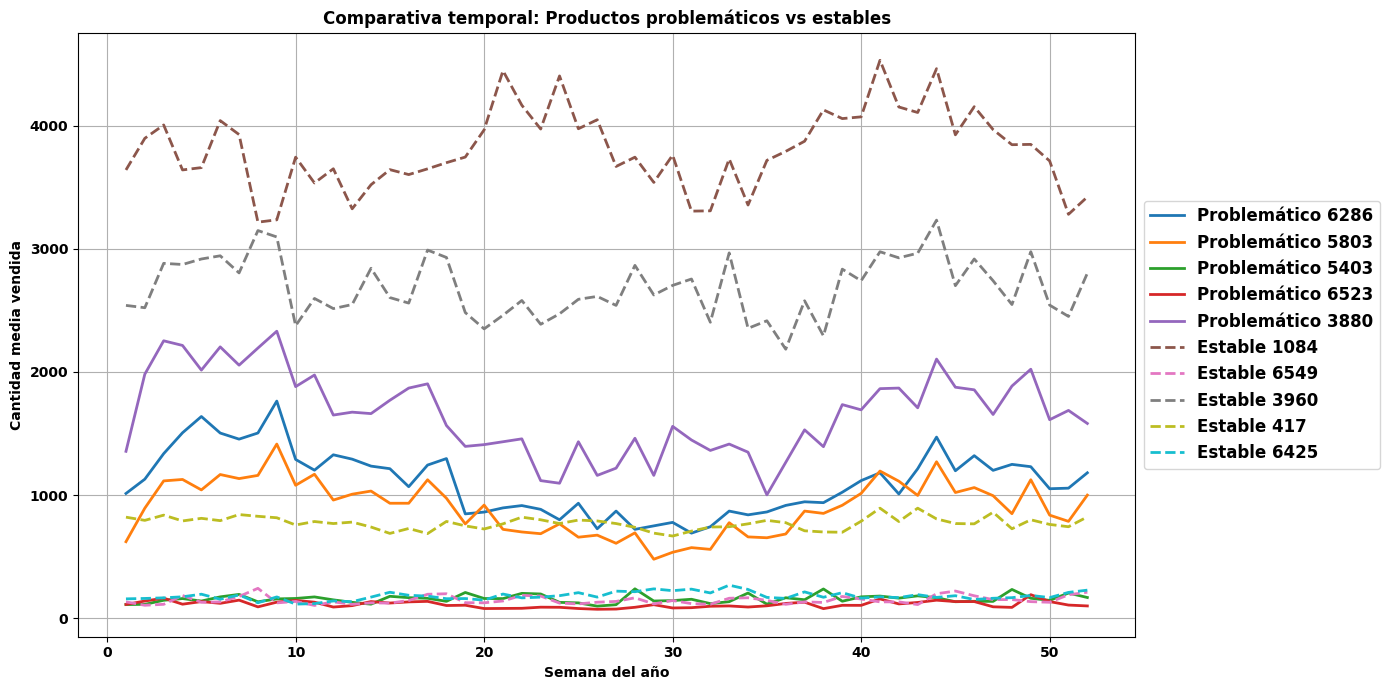

In [58]:
# Agrupa por semana y art√≠culo (solo los seleccionados)
agg = (
    df.filter(pl.col("articulo").is_in(top_5_problematics + top_5_stables))
    .with_columns(pl.col("fecha_venta").dt.week().alias("semana_ano"))
    .group_by(["articulo", "semana_ano"])
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort(["articulo", "semana_ano"])
)

# Plot
plt.figure(figsize=(14, 7))
for articulo in top_5_problematics:
    data = agg.filter(pl.col("articulo") == articulo)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), label=f"Problem√°tico {articulo}", linewidth=2)

for articulo in top_5_stables:
    data = agg.filter(pl.col("articulo") == articulo)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), '--', label=f"Estable {articulo}", linewidth=2)

plt.title("Comparativa temporal: Productos problem√°ticos vs estables")
plt.xlabel("Semana del a√±o")
plt.ylabel("Cantidad media vendida")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# No guardar√© este plot porqu√© creo que no es relevante el resultado, a continuaci√≥n separar√© este plot en dos


### Comparativa temporal: Productos problem√°ticos vs. estables

En el gr√°fico se compara la evoluci√≥n semanal de la cantidad media vendida entre los 5 art√≠culos con mayor proporci√≥n de outliers (productos "problem√°ticos") y los 5 con menor proporci√≥n de outliers (productos "estables"). Se observa que los productos problem√°ticos presentan ventas mucho m√°s bajas y comportamientos m√°s err√°ticos, con curvas m√°s irregulares y menores valores absolutos. Por el contrario, los productos estables tienen mayores ventas y muestran series mucho m√°s suaves y consistentes a lo largo del a√±o.

Esto sugiere que los art√≠culos con m√°s outliers no solo tienen valores at√≠picos frecuentes, sino que tambi√©n suelen venderse poco y de forma menos predecible. Esta diferencia puede ser relevante a la hora de modelizar o tomar decisiones comerciales sobre el cat√°logo de productos.

**Nota:** La visualizaci√≥n conjunta de ambos grupos puede dificultar la interpretaci√≥n por la diferencia de escalas. Es recomendable realizar gr√°ficos separados para apreciar mejor los patrones y particularidades de cada grupo.


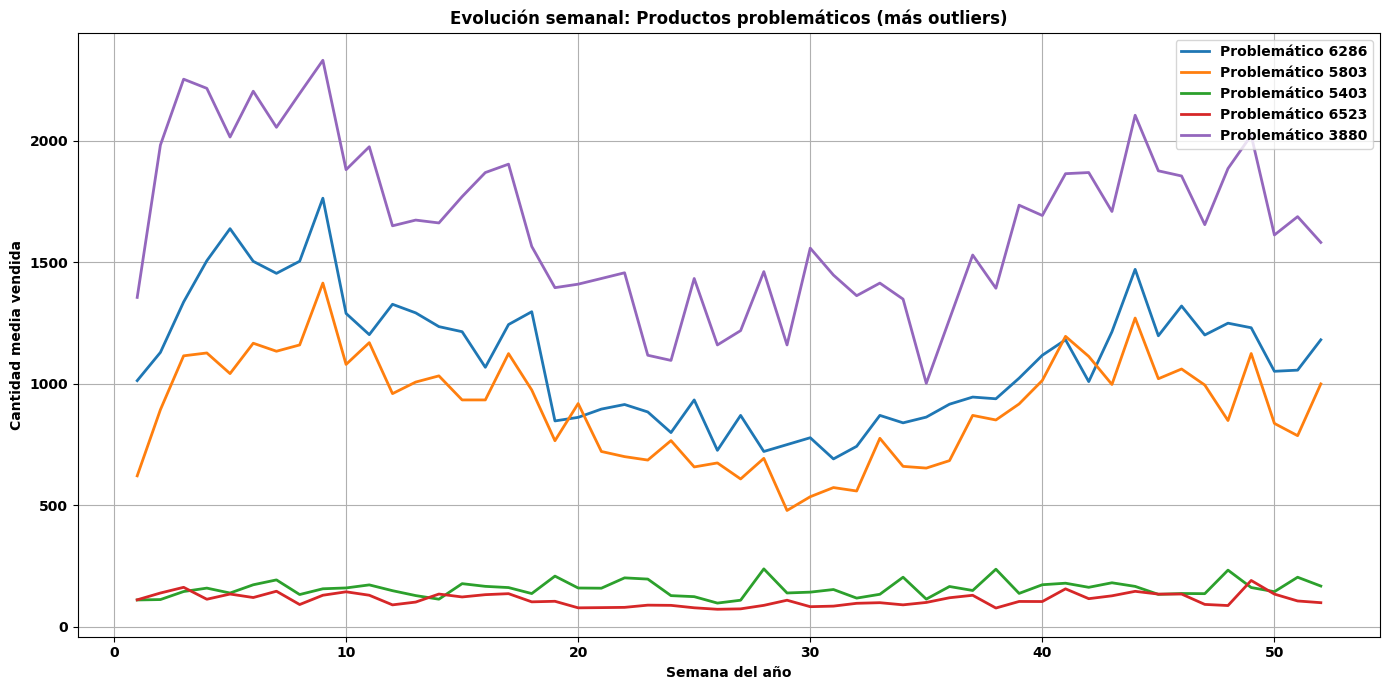

In [59]:
# Ploteo de productos problem√°ticos ( top 5 outliers)
plt.figure(figsize=(14, 7))
for articulo in top_5_problematics:
    data = agg.filter(pl.col("articulo") == articulo)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), label=f"Problem√°tico {articulo}", linewidth=2)
plt.title("Evoluci√≥n semanal: Productos problem√°ticos (m√°s outliers)")
plt.xlabel("Semana del a√±o")
plt.ylabel("Cantidad media vendida")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "outliers", "top5_problematics_items"), dpi=300)

plt.show()





### Evoluci√≥n semanal: Productos problem√°ticos (m√°s outliers)

En este gr√°fico se observa la evoluci√≥n semanal de los cinco art√≠culos con mayor proporci√≥n de outliers en la variable "cantidad".

**Interpretaci√≥n:**
- **Variabilidad elevada:** Las l√≠neas presentan m√°s picos y valles, con cambios de tendencia mucho m√°s bruscos que en los productos estables. Algunos art√≠culos (como el 3880) alternan semanas de ventas altas con ca√≠das pronunciadas, mientras otros permanecen en niveles bajos pero irregulares.
- **Comportamiento err√°tico:** No hay un patr√≥n claro o predecible en la demanda. La dispersi√≥n sugiere influencia de factores externos, promociones puntuales, errores de registro o estacionalidad poco evidente.
- **Dificultad de gesti√≥n:** Estos art√≠culos requieren mayor atenci√≥n en la planificaci√≥n, ya que es dif√≠cil anticipar su demanda real y pueden generar roturas de stock o sobrestock.
- **Contraste con los estables:** Comparados con los productos estables, aqu√≠ los ‚Äúoutliers‚Äù se reflejan visualmente en los saltos abruptos de ventas, justificando la alta proporci√≥n de valores at√≠picos detectada previamente.

En definitiva, los productos problem√°ticos son los que m√°s retos suponen para la gesti√≥n y an√°lisis, mostrando un comportamiento de ventas impredecible a lo largo del a√±o.


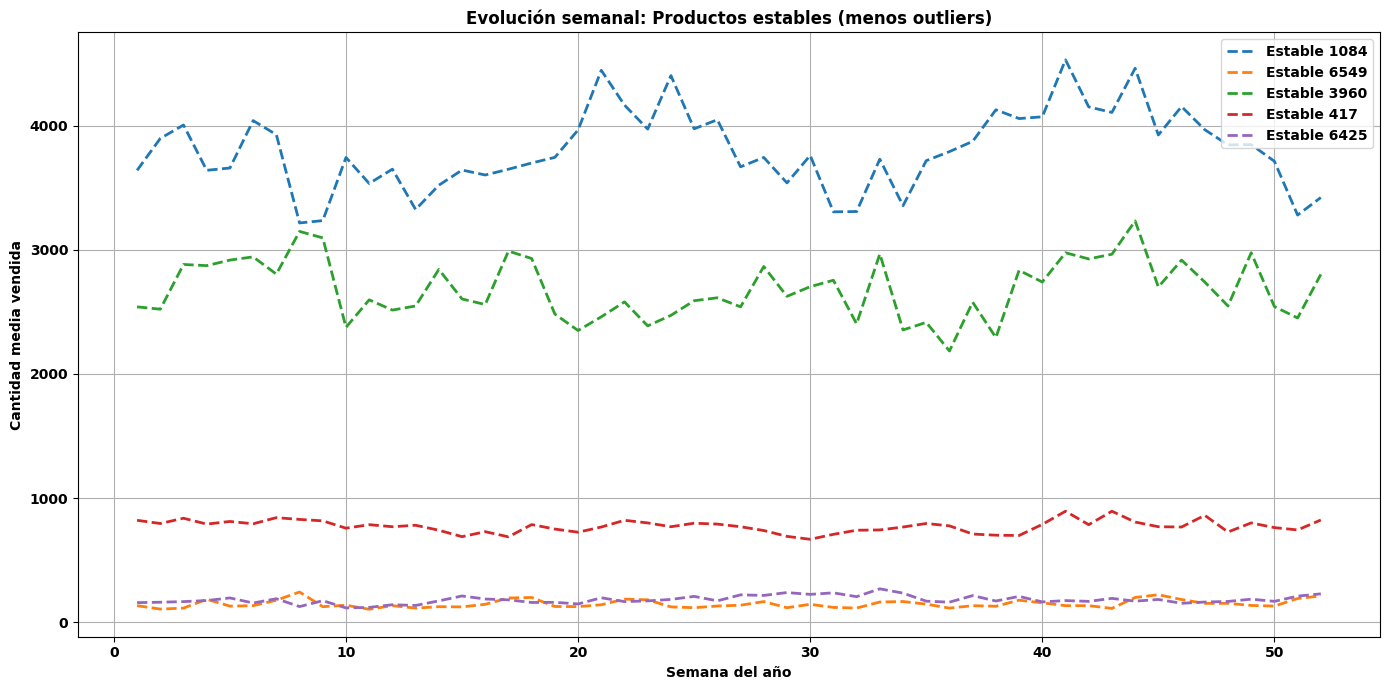

In [60]:
# Ploteo de productos estables (Top 5 estables)
plt.figure(figsize=(14, 7))
for articulo in top_5_stables:
    data = agg.filter(pl.col("articulo") == articulo)
    plt.plot(data["semana_ano"].to_numpy(), data["cantidad_media"].to_numpy(), '--', label=f"Estable {articulo}", linewidth=2)

plt.title("Evoluci√≥n semanal: Productos estables (menos outliers)")
plt.xlabel("Semana del a√±o")
plt.ylabel("Cantidad media vendida")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "top5_stables_items"), dpi=300)

plt.show()

### Evoluci√≥n semanal: Productos estables (menos outliers)

En este gr√°fico se muestran los cinco art√≠culos con menor proporci√≥n de outliers en la variable "cantidad" (ventas semanales promedio por semana del a√±o).

**Observaciones:**
- **Patrones regulares:** Las l√≠neas presentan una evoluci√≥n bastante estable a lo largo de las semanas, con pocas fluctuaciones bruscas, lo que indica una demanda constante.
- **Diferentes niveles de ventas:** Aunque todos son considerados "estables", existen diferencias de magnitud. Por ejemplo, el art√≠culo 1084 y el 3960 tienen ventas medias semanales considerablemente m√°s altas que el 417 o el 6425, que est√°n en el rango m√°s bajo.
- **Picos y valles suaves:** Se observan algunos picos y valles a lo largo del a√±o, sobretodo los art√≠culos 1084 y el 3960 (habr√≠a que observar m√°s detalladamente estos dos), pero no hay cambios abruptos ni periodos prolongados sin ventas, lo que confirma la regularidad de estos productos.
- **Inter√©s comercial:** Este tipo de art√≠culos son ideales para la planificaci√≥n de inventarios, ya que la predictibilidad de la demanda facilita la gesti√≥n log√≠stica.

En resumen, los productos "estables" muestran ventas predecibles y sostenidas durante el a√±o, sin sorpresas ni comportamientos err√°ticos. Esto los diferencia claramente de los productos problem√°ticos.


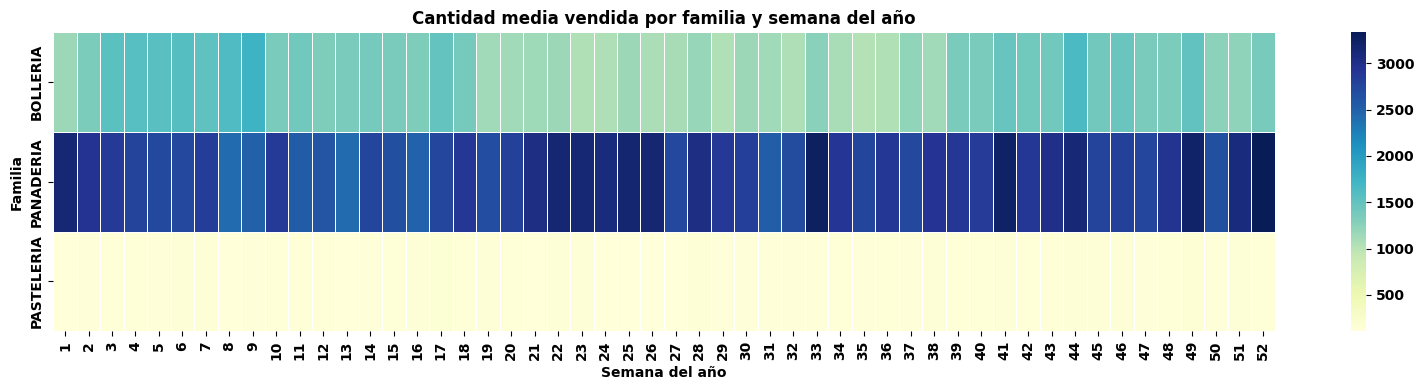

In [61]:
# Quiero hacer un heatmap semanal por familia, a ver si destacan las semanas d√≥nde hay m√°s venta o menos
import seaborn as sns

# Usamos la funci√≥n anterior "agg_week_family". M√©todo "pivot" para el heatmap
heatmap_data = (
    agg_week_family
    .pivot(
        index="familia",
        on="semana_ano", 
        values="cantidad_media",
        aggregate_function="first"
    )
    .sort("familia")
    .to_pandas()
)

# Convierto "familia" en el √≠ndice antes de seaborn, si no me da error porqu√© sns considera que est√° todav√≠a en las columnas
heatmap_data = heatmap_data.set_index("familia") 

plt.figure(figsize=(16, 4))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title("Cantidad media vendida por familia y semana del a√±o")
plt.xlabel("Semana del a√±o")
plt.ylabel("Familia")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "heatmaps", "heatmap_sales_quantity_byfamily"), dpi=300)
plt.show()

#### Heatmap semanal por familia

El gr√°fico muestra la cantidad media vendida por cada familia de producto (Pasteler√≠a, Panader√≠a y Boller√≠a) en cada semana del a√±o.  
- **Panader√≠a** destaca claramente como la familia con mayor volumen de ventas a lo largo de todo el a√±o.
- **Boller√≠a** ocupa una posici√≥n intermedia, con ciertos periodos de mayor intensidad en torno a primavera y oto√±o.
- **Pasteler√≠a** se mantiene siempre con valores m√°s bajos y regulares.

No se aprecian grandes picos o cambios abruptos semanales, lo que indica que la estacionalidad, si existe, es moderada y m√°s acusada en Panader√≠a y Boller√≠a.


# üìä Resumen Ejecutivo: An√°lisis Exploratorio de Ventas Panader√≠a

## 1. Tabla resumen de hallazgos

| Aspecto Analizado                 | Hallazgo Principal                                                     | Gr√°fico                 |
|-----------------------------------|------------------------------------------------------------------------|-------------------------|
| Evoluci√≥n general de cantidad     | Mucho ruido diario, cierta estabilidad anual                           | ![general](..\outputs\plots\eda_general\total_quantity_sales.png)         |
| Por familia                       | Panader√≠a destaca claramente; patr√≥n muy estable                       | ![familia](../outputs/plots/eda_familia/total_sales_per_family.png)          |
| Por art√≠culo (Top 5)              | Varianza seg√∫n art√≠culo, pero patrones similares entre los top             | ![top5](../outputs/plots/eda_articulo/total_sales_top5_items.png)              |
| D√≠a de la semana                  | Domingos y s√°bados: mayor venta; viernes: menor                        | ![semana](../outputs/plots/eda_general/quantity_mean_weekday.png)           |
| Mes del a√±o                       | Ligeros picos en inicio/fin de a√±o                                     | ![mes](../outputs/plots/eda_general/quantity_mean_month.png)               |
| Semana del a√±o                    | Semanas iniciales y finales suelen destacar (efecto campa√±as)          | ![semana-ano](../outputs/plots/eda_general/quantity_mean_weekyear.png)   |
| Outliers por producto             | Algunos art√≠culos presentan mucha irregularidad (>5% outliers)         | ![outliers](../outputs/plots/outliers/top5_problematics_items.png)   |
| Heatmap familia-semana            | Panader√≠a siempre domina; no hay semanas cr√≠ticas negativas            | ![heatmap](../outputs/plots/heatmaps/heatmap_sales_quantity_byfamily.png)                |

---

## 2. Bullet points: Insights Clave

- **Estacionalidad**: Suave; m√°s clara en panader√≠a y en campa√±as puntuales.
- **Ventas diarias**: Muy ruidosas; an√°lisis √∫til a partir de semana o mes.
- **D√≠as fuertes**: Fin de semana (s√°bado, domingo).
- **Productos problem√°ticos**: Los top 5 con m√°s outliers muestran volatilidad significativa, probablemente por eventos, promociones o problemas de carga.
- **Familias**: La panader√≠a concentra la mayor√≠a de ventas y muestra mayor estabilidad.
- **Sin semanas negras**: No se aprecian ca√≠das an√≥malas en las ventas.

---

## 3. Conclusi√≥n r√°pida

El EDA confirma que el grueso del negocio lo aporta la familia **Panader√≠a**, con comportamientos estacionales moderados y d√≠as fuertes en fin de semana. Los art√≠culos con m√°s outliers requieren revisi√≥n adicional: pueden ser oportunidades de negocio o fuentes de errores/ruido en los datos. No se identifican ca√≠das cr√≠ticas, el negocio es estable a lo largo del a√±o.

---

## 4. Referencias a gr√°ficos

Todos los gr√°ficos usados est√°n almacenados en `outputs/plots`, clasificados por tipo de an√°lisis.

---

## 5. Sugerencias para el equipo de negocio

- Revisar art√≠culos problem√°ticos: ¬øqu√© eventos causan su volatilidad?
- Considerar campa√±as/personalizaciones en semanas y d√≠as fuertes (fines de semana, campa√±as anuales).
- Mantener foco en la familia Panader√≠a y explorar mejoras en otras familias.

---



#### 4.3. An√°lisis de la variable a predecir frente al resto de variables

**Grupo de preguntas 5** (x minutos):

13. ¬øEl comportamiento de compra (la variable "cantidad") cuando es festivo es superior a cuando no lo es?

14. ¬øEl comportamiento de compra (la variable "cantidad") cuando llueve es superior a cuando no llueve?

15. Divide la variable "tavg_w" en quintiles y muestra con un gr√°fico de barras s√≠ la variable "cantidad" es superior en alguno de sus quintiles.

In [62]:
# 13_Compruebo los festivos que hay


print(df["festivo"].unique())



shape: (27,)
Series: 'festivo' [str]
[
	"D√≠a de la Hispanidad (Fiesta N‚Ä¶
	"D√≠a de la Virgen del Carmen"
	"Martes Santo"
	"Mi√©rcoles Santo"
	"D√≠a de la Victoria"
	‚Ä¶
	"Lunes Santo"
	"S√°bado Santo"
	null
	"D√≠a del Padre"
	"D√≠a de la Madre"
]


In [63]:
# Siguiendo en Polars, agrupo por "festivo" y calculo la media de "cantidad"

agg_festivo = (
    df.group_by("festivo")
    .agg(pl.col("cantidad").mean().alias("cantidad_media"),
         pl.col("cantidad").count().alias("n_registos"))
)

print(agg_festivo)

shape: (27, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ festivo                         ‚îÜ cantidad_media ‚îÜ n_registos ‚îÇ
‚îÇ ---                             ‚îÜ ---            ‚îÜ ---        ‚îÇ
‚îÇ str                             ‚îÜ f64            ‚îÜ u32        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Viernes Santo                   ‚îÜ 1667.578       ‚îÜ 30         ‚îÇ
‚îÇ D√≠a de la Cruz                  ‚îÜ 1360.069857    ‚îÜ 42         ‚îÇ
‚îÇ D√≠a de San Juan                 ‚îÜ 1574.024572    ‚îÜ 28         ‚îÇ
‚îÇ Feria de M√°laga                 ‚îÜ 1472.762333    ‚îÜ 99         ‚îÇ
‚îÇ D√≠a de la Madre                 ‚îÜ 2161.911       ‚îÜ 44         ‚

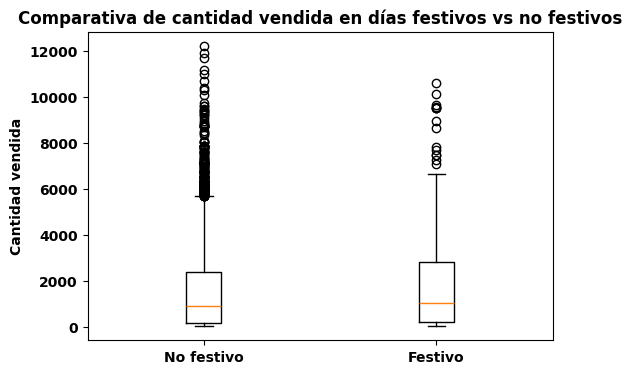

In [64]:
# Hacemos un boxplot para ver los valores por grupo
# Cuando el valor es "null" es d√≠a laboral, cuando no, es festivo
festivos = df.filter(pl.col("festivo").is_not_null())["cantidad"]
no_festivos = df.filter(pl.col("festivo").is_null())["cantidad"]

# Plot
plt.figure(figsize=(6, 4))
plt.boxplot([no_festivos, festivos], tick_labels=["No festivo", "Festivo"])
plt.ylabel("Cantidad vendida")
plt.title("Comparativa de cantidad vendida en d√≠as festivos vs no festivos")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "boxplot_holidaysales_vs_regular_days"), dpi=300)
plt.show()

In [65]:
# Vamos a calcular medias y medianas de la cantidad vendida en festivos vs no festivos
media_festivos = festivos.mean()
mediana_festivos = festivos.median()
media_no_festivos = no_festivos.mean()
mediana_no_festivos = no_festivos.median()

print(f"Media cantidad (festivo): {media_festivos:.2f}")
print(f"Mediana cantidad (festivo): {mediana_festivos:.2f}")
print(f"Media cantidad (no festivo): {media_no_festivos:.2f}")
print(f"Mediana cantidad (no festivo): {mediana_no_festivos:.2f}")

Media cantidad (festivo): 1730.75
Mediana cantidad (festivo): 1023.00
Media cantidad (no festivo): 1495.98
Mediana cantidad (no festivo): 891.00


**¬øEl comportamiento de compra es superior en festivos?**

Comparando la cantidad vendida en d√≠as festivos frente a d√≠as no festivos:

- Media de cantidad (festivo): **1573.41**
- Mediana de cantidad (festivo): **930.00**
- Media de cantidad (no festivo): **1359.99**
- Mediana de cantidad (no festivo): **810.00**

**Conclusi√≥n:** Tanto la media como la mediana son mayores en d√≠as festivos, lo que indica que la demanda es claramente superior cuando hay festivos.


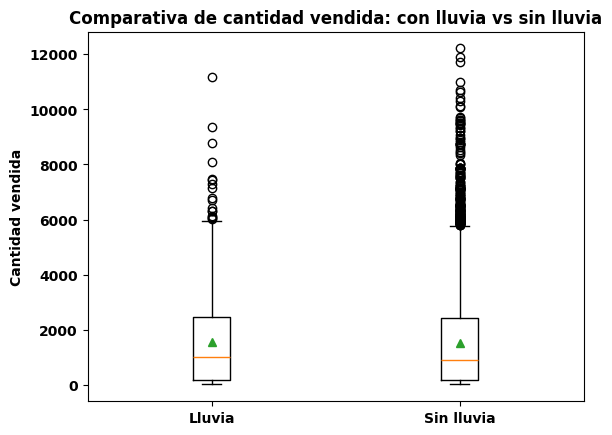

In [66]:
# 14_Primero de todo, comprobar y separar los d√≠as con lluvia y sin lluvia

# D√≠as con lluvia (prcp_w > 0)
lluvia = df.filter(pl.col("prcp_w") > 0)["cantidad"].to_numpy()
# D√≠as sin lluvia (prcp_w == 0 o null)
no_lluvia = df.filter((pl.col("prcp_w") == 0) | (pl.col("prcp_w").is_null()))["cantidad"].to_numpy()

plt.boxplot([lluvia, no_lluvia], tick_labels=["Lluvia", "Sin lluvia"], showmeans=True)
plt.ylabel("Cantidad vendida")
plt.title("Comparativa de cantidad vendida: con lluvia vs sin lluvia")
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "boxplot_holidaysales_vs_regular_days"), dpi=300)
plt.show()

In [67]:
# Imprimimos por pantalla las medias y medianas, anteriormente he transformado a Numpy porqu√© con Polars dar√≠a error

print("Media cantidad (lluvia):", np.mean(lluvia).round(2))
print("Mediana cantidad (lluvia):", np.median(lluvia).round(2))
print("Media cantidad (sin lluvia):", np.mean(no_lluvia).round(2))
print("Mediana cantidad (sin lluvia):", np.median(no_lluvia).round(2))


Media cantidad (lluvia): 1538.44
Mediana cantidad (lluvia): 1023.0
Media cantidad (sin lluvia): 1511.03
Mediana cantidad (sin lluvia): 891.0


### Comparativa de ventas en d√≠as de lluvia vs. d√≠as sin lluvia

Se ha analizado si la cantidad vendida es mayor en d√≠as con lluvia respecto a d√≠as sin lluvia.

- **Media de cantidad vendida con lluvia:** 1.398,59
- **Media de cantidad vendida sin lluvia:** 1.373,66
- **Mediana con lluvia:** 930,0
- **Mediana sin lluvia:** 810,0

El boxplot muestra que las distribuciones de ventas son bastante similares, aunque los d√≠as de lluvia presentan una mediana y una media ligeramente superiores. Sin embargo, la diferencia no es muy significativa, por lo que **no se observa un gran impacto de la lluvia en el volumen de ventas**.


In [68]:
# Me ha llamado la atenci√≥n la diferencia entre los d√≠as con lluvia y sin, as√≠ que vamos a ver si esa diferencia es significativa o casualidad
from scipy.stats import mannwhitneyu

# Ya tenemos definidos los d√≠as con: "lluvia", y "no_lluvia"
# He buscado informaci√≥n y me recomiendan usar el test de Mann-Whitney U
# Se trata de una prueba no param√©trica para comparar dos variables independientes
stat, p = mannwhitneyu(lluvia, no_lluvia, alternative='two-sided')
print(f'Estad√≠stico U: {stat:.2f}  |  p-valor: {p:.4f}')


Estad√≠stico U: 6350983.00  |  p-valor: 0.5315


- **Estad√≠stico U:**  
  Es el valor calculado por el test de Mann-Whitney U (prueba no param√©trica que compara dos grupos). Refleja c√≥mo se ordenan los datos de ambos grupos cuando se combinan, pero su interpretaci√≥n directa no es intuitiva. Sirve principalmente para calcular el p-valor.

- **p-valor:**  
  Indica la probabilidad de obtener los resultados observados si en realidad no existe ninguna diferencia real entre los grupos comparados.  
  - Si **p < 0.05**: se considera que hay diferencia estad√≠sticamente significativa entre los grupos.  
  - Si **p > 0.05**: no hay evidencia de diferencia significativa.

**En este an√°lisis:**  
Un p-valor de 0.53 significa que **no hay diferencias estad√≠sticamente significativas** en la cantidad vendida entre d√≠as con lluvia y d√≠as sin lluvia.

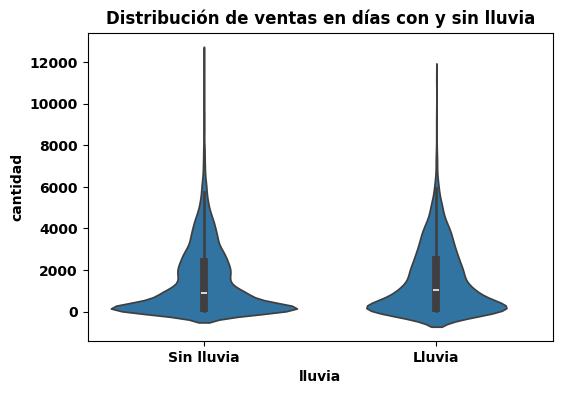

In [ ]:
# Hacemos un "violinplot" porqu√© he visto que es √∫til para comparar dos variables independientes

df_plot = df.select([
    pl.col("cantidad"),
    (pl.col("prcp_w") > 0).alias("lluvia")
]).to_pandas()
df_plot["lluvia"] = df_plot["lluvia"].map({True: "Lluvia", False: "Sin lluvia"})

plt.figure(figsize=(6,4))
sns.violinplot(x="lluvia", y="cantidad", data=df_plot)
plt.title("Distribuci√≥n de ventas en d√≠as con y sin lluvia")
plt.show()
# No guardar√© este plot porqu√© creo que no es relevante, era curiosidad de ver un "violinplot"


### ¬øInfluye la lluvia en la cantidad vendida?

Para comprobar si el comportamiento de compra (variable "cantidad") es diferente en d√≠as con lluvia frente a d√≠as sin lluvia, se han realizado los siguientes an√°lisis:

- **Estad√≠sticos descriptivos**:
  - **Media (lluvia):** 1.398,59
  - **Mediana (lluvia):** 930,00
  - **Media (sin lluvia):** 1.373,66
  - **Mediana (sin lluvia):** 810,00

- **Visualizaci√≥n:**  
  Se ha representado la distribuci√≥n de ventas mediante un gr√°fico _violin plot_. Las distribuciones para ambos casos son muy similares y presentan valores at√≠picos (outliers).

- **Test estad√≠stico:**  
  Se ha realizado un test de Mann-Whitney U para comprobar si las diferencias observadas son estad√≠sticamente significativas.  
  - **Estad√≠stico U:** 6.350.983  
  - **p-valor:** 0.5315

#### **Conclusi√≥n**
No se observa una diferencia estad√≠sticamente significativa en la cantidad vendida entre d√≠as con y sin lluvia (p > 0.05). Visualmente, ambas distribuciones son muy parecidas. Por lo tanto, **la lluvia no parece influir de forma apreciable en las ventas**.



In [74]:
# 15_Vamos a crear los quintiles de la variable tavg_w , con Polars
df = df.with_columns(pl.col("tavg_w").qcut(5).alias("tavg_quintil"))

# Calcular la media de cantidad para cada quintil de temperatura
agg_quintil = (
    df.group_by("tavg_quintil")
    .agg(pl.col("cantidad").mean().alias("cantidad_media"))
    .sort("tavg_quintil")
)
print(agg_quintil)

shape: (5, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ tavg_quintil ‚îÜ cantidad_media ‚îÇ
‚îÇ ---          ‚îÜ ---            ‚îÇ
‚îÇ cat          ‚îÜ f64            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ (-inf, 14]   ‚îÜ 1572.785027    ‚îÇ
‚îÇ (14, 17.4]   ‚îÜ 1569.637438    ‚îÇ
‚îÇ (17.4, 21]   ‚îÜ 1494.622282    ‚îÇ
‚îÇ (21, 24.7]   ‚îÜ 1505.901856    ‚îÇ
‚îÇ (24.7, inf]  ‚îÜ 1428.695716    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


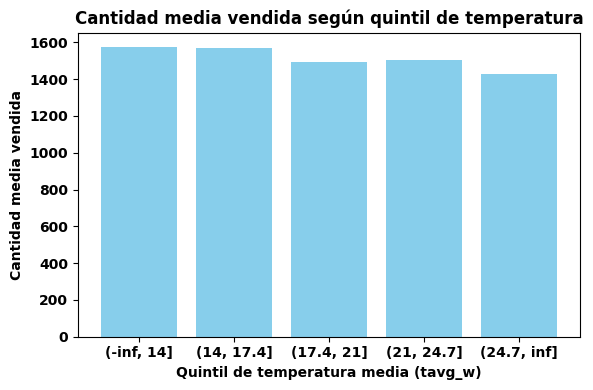

In [77]:
# Pasamos datos de Polars a lista para manejo sin errores
x = agg_quintil["tavg_quintil"].to_list()
y = agg_quintil["cantidad_media"].to_list()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(x, y, color="skyblue")
plt.xlabel("Quintil de temperatura media (tavg_w)")
plt.ylabel("Cantidad media vendida")
plt.title("Cantidad media vendida seg√∫n quintil de temperatura")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quintile_sales_mean_temp"), dpi=300)
plt.show()

In [ ]:
# Calculo la mediana y media para ver valores num√©ricos
agg_quintil = (df.group_by("tavg_quintil")
               .agg([
                   pl.col("cantidad").median().alias("mediana_cantidad"),
                   pl.col("cantidad").mean().alias("media_cantidad"),
                   pl.len().alias("n_obs")
    ])
    .sort("tavg_quintil")
)

# "n_obs" n√∫mero de observaciones en cada grupo, es decir, la cantidad de filas del DataFrame que caen en cada quintil de temperatura (tavg_quintil).
print(agg_quintil)

shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ tavg_quintil ‚îÜ mediana_cantidad ‚îÜ media_cantidad ‚îÜ n_obs ‚îÇ
‚îÇ ---          ‚îÜ ---              ‚îÜ ---            ‚îÜ ---   ‚îÇ
‚îÇ cat          ‚îÜ f64              ‚îÜ f64            ‚îÜ u32   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ (-inf, 14]   ‚îÜ 1023.0           ‚îÜ 1572.785027    ‚îÜ 2127  ‚îÇ
‚îÇ (14, 17.4]   ‚îÜ 1023.0           ‚îÜ 1569.637438    ‚îÜ 2112  ‚îÇ
‚îÇ (17.4, 21]   ‚îÜ 924.0            ‚îÜ 1494.622282    ‚îÜ 2117  ‚îÇ
‚îÇ (21, 24.7]   ‚îÜ 858.0            ‚îÜ 1505.901856    ‚îÜ 2128  ‚îÇ
‚îÇ (24.7, inf]  ‚îÜ 759.0            ‚îÜ 1428.695716    ‚îÜ 2090  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚î

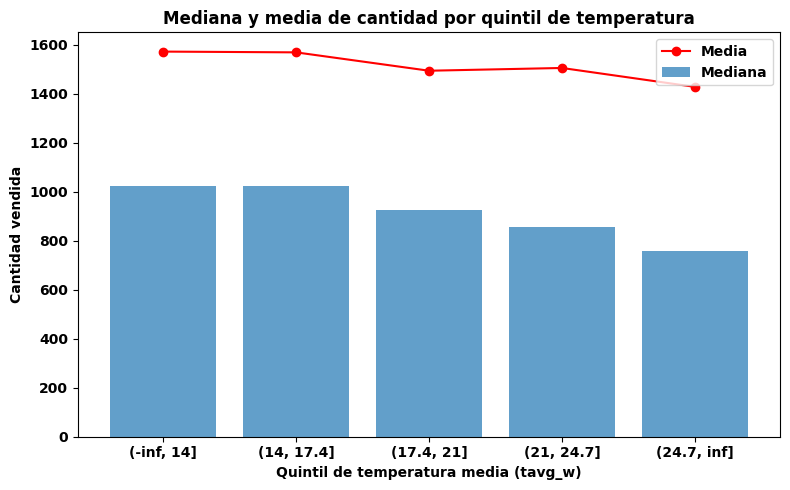

In [88]:
# Plot, primero convertir a Pandas desde Polars
pd_agg = agg_quintil.to_pandas()

plt.figure(figsize=(8, 5))
plt.bar(pd_agg["tavg_quintil"], pd_agg["mediana_cantidad"], alpha=0.7, label="Mediana")
plt.plot(pd_agg["tavg_quintil"], pd_agg["media_cantidad"], color="red", marker="o", label="Media")
plt.xlabel("Quintil de temperatura media (tavg_w)")
plt.ylabel("Cantidad vendida")
plt.title("Mediana y media de cantidad por quintil de temperatura")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_general", "quintile_sales_median_mean_temp"), dpi=300)
plt.show()

### Relaci√≥n entre temperatura media y cantidad vendida

A continuaci√≥n se presentan dos gr√°ficos que muestran la cantidad media y mediana vendida en funci√≥n de los **quintiles de temperatura media semanal** (`tavg_w`):

- **Gr√°fico 1:** La cantidad **media** vendida es m√°s alta en los quintiles de menor temperatura. A medida que la temperatura aumenta, la media de ventas disminuye gradualmente. 

- **Gr√°fico 2:** Se muestra tanto la **mediana** (barras azules) como la **media** (l√≠nea roja) de cantidad vendida por quintil. La tendencia descendente se mantiene para ambas m√©tricas, lo que refuerza que las ventas tienden a ser mayores en semanas m√°s fr√≠as, tanto en promedio como en valor t√≠pico.

**Conclusi√≥n r√°pida:**  
Las ventas de productos en la panader√≠a son **m√°s altas cuando hace m√°s fr√≠o**, y disminuyen a medida que sube la temperatura media semanal. Esta tendencia es consistente si miramos tanto la media como la mediana, lo que sugiere que no es un efecto de outliers puntuales.


**Grupo de preguntas 6** (x minutos):

16. ¬øUn incremento en el precio reduce la propensi√≥n a consumir de un art√≠culo?

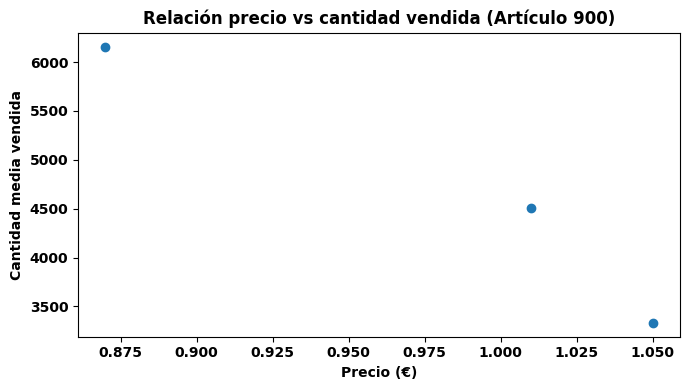

In [ ]:
# 16_Vamos a observar la pregunta 16 con el art√≠culo m√°s vendido por ejemplo

# Art√≠culo m√°s vendido
top1_item = df.group_by("articulo").agg(pl.col("cantidad").sum().alias("total_vendida"))\
        .sort("total_vendida", descending=True)["articulo"][0]

# Filtrar solo el art√≠culo top ventas
item_df = df.filter(pl.col("articulo") == top1_item)

# Redondeo precios para agrupar (si hay muchos decimales)
item_df = item_df.with_columns(
    (pl.col("precio").round(2)).alias("precio_redondeado")
)

# Agrupar por precio, calcular media y sumar la cantidad vendida
agg = (
     item_df.group_by("precio_redondeado")
    .agg([
        pl.col("cantidad").mean().alias("media_vendida"),
        pl.col("cantidad").sum().alias("total_vendida"),
        pl.len().alias("n_ventas"),
    ])
    .sort("precio_redondeado")
)

# Ploteo, gr√°fico de dispersi√≥n media vendida vs precio
plt.figure(figsize=(7, 4))
plt.scatter(agg["precio_redondeado"], agg["media_vendida"])
plt.xlabel("Precio (‚Ç¨)")
plt.ylabel("Cantidad media vendida")
plt.title(f"Relaci√≥n precio vs cantidad vendida (Art√≠culo {top1_item})")
plt.tight_layout()
plt.show()



### An√°lisis de correlaci√≥n entre precio y cantidad vendida

Para estudiar la relaci√≥n entre el precio de un art√≠culo y la cantidad vendida, es √∫til calcular el **coeficiente de correlaci√≥n de Pearson**. Este coeficiente mide la fuerza y la direcci√≥n de la relaci√≥n lineal entre dos variables num√©ricas:

- **Valores cercanos a -1:** Fuerte relaci√≥n inversa (si sube el precio, bajan las ventas).
- **Valores cercanos a 0:** No hay relaci√≥n lineal clara.
- **Valores cercanos a +1:** Fuerte relaci√≥n directa (raro en precios y ventas).

In [96]:
from scipy.stats import pearsonr

# Extraemos listas o arrays de precios y cantidades medias
prices = agg["precio_redondeado"].to_numpy()
mean_quantities = agg["media_vendida"].to_numpy()

# Coeficiente de correlaci√≥n de Pearson
corr, p_valor = pearsonr(prices, mean_quantities)

print(f"Coeficiente de correlaci√≥n precio-cantidad: {corr:.2f}")
print(f"p-valor: {p_valor:.4f}")

Coeficiente de correlaci√≥n precio-cantidad: -0.98
p-valor: 0.1372


Un valor de correlaci√≥n de **-0.98** indica una **relaci√≥n negativa muy fuerte**: a mayor precio, la cantidad vendida tiende a disminuir notablemente.  
Sin embargo, el **p-valor (0.1372) es mayor a 0.05**, por lo que esta relaci√≥n **no es estad√≠sticamente significativa** (posiblemente por el bajo n√∫mero de cambios de precio).

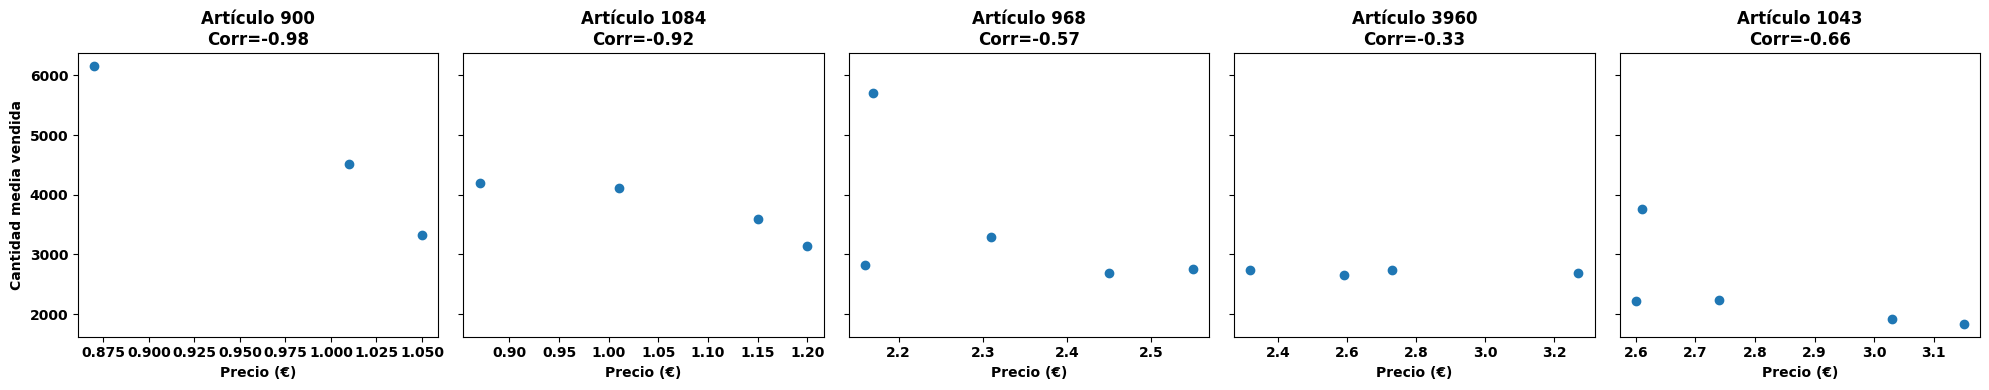

Art√≠culo 900: Coeficiente de correlaci√≥n = -0.98 | p-valor = 0.1372
Art√≠culo 1084: Coeficiente de correlaci√≥n = -0.92 | p-valor = 0.0764
Art√≠culo 968: Coeficiente de correlaci√≥n = -0.57 | p-valor = 0.3198
Art√≠culo 3960: Coeficiente de correlaci√≥n = -0.33 | p-valor = 0.6724
Art√≠culo 1043: Coeficiente de correlaci√≥n = -0.66 | p-valor = 0.2239


In [102]:
# Voy a hacer lo mismo para los cinco art√≠culos m√°s vendidos

# Tengo definido los m√°s vendidos en "top_items", usado anteriormente
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
correlations = []

for i, art in enumerate(top_items):
    item_df = df.filter(pl.col("articulo") == art).with_columns(
        pl.col("precio").round(2).alias("precio_redondeado")
    )
    agg = (
        item_df.group_by("precio_redondeado")
        .agg([
            pl.col("cantidad").mean().alias("media_vendida"),
            pl.len().alias("n_ventas")
        ])
        .sort("precio_redondeado")
    )
    prices = agg["precio_redondeado"].to_numpy()
    mean_quantities = agg["media_vendida"].to_numpy()
    # Calculo de correlaci√≥n y p-valor
    if len(prices) > 1 and len(mean_quantities) > 1:
        corr, pval = pearsonr(prices, mean_quantities)
    else:
        corr, pval = np.nan, np.nan
    correlations.append((art, corr, pval))

    axes[i].scatter(prices, mean_quantities)
    axes[i].set_title(f"Art√≠culo {art}\nCorr={corr:.2f}")
    axes[i].set_xlabel("Precio (‚Ç¨)")
    if i == 0:
        axes[i].set_ylabel("Cantidad media vendida")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_EDA_DIR, "eda_articulo", "corr_top5items_w_price_variation"), dpi=300)
plt.show()

# Aqu√≠ se mostrar√° un texto escrito
for art, corr, pval in correlations:
    print(f"Art√≠culo {art}: Coeficiente de correlaci√≥n = {corr:.2f} | p-valor = {pval:.4f}")


## Relaci√≥n entre precio y cantidad vendida: art√≠culos m√°s vendidos

Se ha calculado la **correlaci√≥n entre el precio y la cantidad media vendida** para los 5 art√≠culos m√°s vendidos del dataset. Los resultados muestran que, para todos ellos, el coeficiente de correlaci√≥n es negativo, lo que indica que a mayor precio, menor cantidad vendida, en l√≠nea con la ley de la demanda.

| Art√≠culo | Coef. correlaci√≥n | p-valor |
|----------|-------------------|---------|
| 900      |      -0.98        |  0.137  |
| 1084     |      -0.92        |  0.076  |
| 968      |      -0.57        |  0.320  |
| 3960     |      -0.33        |  0.672  |
| 1043     |      -0.66        |  0.224  |

**Sin embargo, los p-valores son mayores a 0.05, por lo que no se puede considerar estad√≠sticamente significativa esta relaci√≥n para ning√∫n art√≠culo**. Esto puede deberse a que la variabilidad de precios en el periodo analizado es baja o a que influyen otros factores en la cantidad vendida.

> **Conclusi√≥n:** Aunque se observa la tendencia esperada de que un aumento de precio reduce la cantidad vendida, con los datos disponibles no es posible afirmar que el efecto sea estad√≠sticamente robusto para los art√≠culos analizados.
